In [1]:
%run imports.ipynb
%run _shared_setup.ipynb

docker image: podpearson/biipy_rdp:latest


In [2]:
# Has been fixed in Docker image, but needs to be recreated
!chmod a+x /usr/local/bin/vcf2npy
!vcf2npy --help

usage: vcf2npy [-h] [--vcf FILE] [--fasta FASTA] [--output-dir DIR] [--array-type ARRAY_TYPE] [--chromosome CHROMOSOME] [--task-size BP] [--task-index N] [--region REGION]
               [--exclude-field FIELD] [--ploidy PLOIDY] [--dtype FIELD:DTYPE] [--arity FIELD:ARITY] [--progress N] [--no-truncate]

optional arguments:
  -h, --help            show this help message and exit
  --vcf FILE            input VCF file
  --fasta FASTA         reference genome as FASTA file (only required if --task-size is given)
  --output-dir DIR      output directory (omit to use default vcfnp cache directory)
  --array-type ARRAY_TYPE
                        array type, one of [variants|calldata|calldata_2d]
  --chromosome CHROMOSOME
                        chromosome to extract (omit to extract whole genome)
  --task-size BP        size (in base pairs) of region to extract (omit to extract whole chromosome)
  --task-index N        task index as integer or string to get task from environment variable (

In [3]:
# Has been fixed in Docker file, but needs to be recreated
!Rscript -e 'source("http://bioconductor.org/biocLite.R"); biocLite("ggplot2")'

Bioconductor version 3.2 (BiocInstaller 1.20.1), ?biocLite for help
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.2 (BiocInstaller 1.20.1), R 3.2.2 (2015-08-14).
Installing package(s) 'ggplot2'
trying URL 'https://cran.rstudio.com/src/contrib/ggplot2_2.0.0.tar.gz'
Content type 'application/x-gzip' length 1546130 bytes (1.5 MB)
downloaded 1.5 MB

* installing *source* package 'ggplot2' ...
** package 'ggplot2' successfully unpacked and MD5 sums checked
** R
** data
*** moving datasets to lazyload DB
** inst
** preparing package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded
* DONE (ggplot2)

The downloaded source packages are in
	'/tmp/RtmpxBL6R6/downloaded_packages'
Old packages: 'MASS', 'Matrix', 'class', 'mgcv', 'nlme', 'nnet', 'spatial'


# Plan
- Run VQSR on Release 4 and Interim 5 call sets
    - as builds (to sanity check)
    - Using 7 chromosomes only (Gil suggestion)
    - Using GATK 3.5
    - Using release 4 as training set
    - 4 Gaussians for SNPs
    - Removing ReadPosRankSum and MQRankSum
    - Removing ReadPosRankSum and MQRankSum and FS
    - Lowering VQSR_PRIOR
- Create hard filtered r4 and i5 callsets using GATK recommendations
- Run VQSR on hard filtered Release 4 and Interim 5 call sets
- Analyses
    - VQSLOD plots: old/new r4 vs old/new i5
    - Numbers of PASS SNPs and indels old vs new, r4 and i5

- Possible but unlikely
    - Manually run VQSR on intersection of SNPs between Release 4 and Interim 5 call sets
    - Run VQSR on intersection SNPs on subsets of input parameters
- Once key problems fixed, manually create new vcf file, and give to Joe as interim


# Setup

In [4]:
plot_dir = '/home/Documents/projects/Pf3k_techbm/slides/20160125_pf3k_callset_decision'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [5]:
release4_pass_sites_fn = WG_VCF_FNS['release4'].replace('sites.vcf', 'pass_sites.vcf')
release4_10pc_pass_sites_fn = WG_VCF_FNS['release4'].replace('sites.vcf', '10pc_pass_sites.vcf')
release4_hard_filtered_gatkrec_fn = WG_VCF_FNS['release4'].replace('sites.vcf', 'gatkrec_sites.vcf')
release4_hard_filtered_stringent_fn = WG_VCF_FNS['release4'].replace('sites.vcf', 'stringent_sites.vcf')
interim5_hard_filtered_gatkrec_fn = WG_VCF_FNS['interim5'].replace('sites.vcf', 'gatkrec_sites.vcf')
interim5_hard_filtered_stringent_fn = WG_VCF_FNS['interim5'].replace('sites.vcf', 'stringent_sites.vcf')

training_vcfs_dict = collections.OrderedDict()
training_vcfs_dict['production_build']={
    '7g8_gb4': '/data/plasmodium/pfalciparum/pf-crosses/data/public/1.0/7g8_gb4.combined.final.vcf.gz',
    'hb3_dd2': '/data/plasmodium/pfalciparum/pf-crosses/data/public/1.0/hb3_dd2.combined.final.vcf.gz',
    '3d7_hb3': '/data/plasmodium/pfalciparum/pf-crosses/data/public/1.0/3d7_hb3.combined.final.vcf.gz',
}
training_vcfs_dict['odd_chromosomes']={
    '7g8_gb4': '/nfs/team112_internal/rp7/data/pf3k/vqsr_training_sets/7g8_gb4.combined.final.odd_chromosomes.vcf.gz',
    'hb3_dd2': '/nfs/team112_internal/rp7/data/pf3k/vqsr_training_sets/hb3_dd2.combined.final.odd_chromosomes.vcf.gz',
    '3d7_hb3': '/nfs/team112_internal/rp7/data/pf3k/vqsr_training_sets/3d7_hb3.combined.final.odd_chromosomes.vcf.gz',
}
training_vcfs_dict['pf3k_release4']={
    'pf3k_release4': release4_pass_sites_fn,
}
training_vcfs_dict['pf3k_release4_10pc']={
    'pf3k_release4_10pc': release4_10pc_pass_sites_fn,
}
training_vcfs_dict['release4_hard_filtered_gatkrec']={
    'release4_hard_filtered_gatkrec': release4_hard_filtered_gatkrec_fn,
}
training_vcfs_dict['release4_hard_filtered_stringent']={
    'release4_hard_filtered_stringent': release4_hard_filtered_stringent_fn,
}
training_vcfs_dict['interim5_hard_filtered_gatkrec']={
    'interim5_hard_filtered_gatkrec': interim5_hard_filtered_gatkrec_fn,
}
training_vcfs_dict['interim5_hard_filtered_stringent']={
    'interim5_hard_filtered_stringent': interim5_hard_filtered_stringent_fn,
}

if not os.path.exists(os.path.dirname(training_vcfs_dict['odd_chromosomes']['7g8_gb4'])):
    os.makedirs(os.path.dirname(training_vcfs_dict['odd_chromosomes']['7g8_gb4']))


In [6]:
gatk_exe="java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar"

In [22]:
vqsr_experiments = collections.OrderedDict()
vqsr_experiments['production_build'] = {
    'training_vcfs': training_vcfs_dict['production_build'],
    'vqsr_prior': 15,
    'vqsr_annotations': "-an QD -an MQ -an MQRankSum -an ReadPosRankSum -an FS -an SOR -an DP",
    'max_gaussians': 8,
    'gatk_exe': "java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
    'badLodCutoff': -5.0,
}
vqsr_experiments['odd_chromosomes'] = {
    'training_vcfs': training_vcfs_dict['odd_chromosomes'],
    'vqsr_prior': 15,
    'vqsr_annotations': "-an QD -an MQ -an MQRankSum -an ReadPosRankSum -an FS -an SOR -an DP",
    'max_gaussians': 8,
    'gatk_exe': "java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
    'badLodCutoff': -5.0,
}
vqsr_experiments['no_ranksum'] = {
    'training_vcfs': training_vcfs_dict['production_build'],
    'vqsr_prior': 15,
    'vqsr_annotations': "-an QD -an MQ -an FS -an SOR -an DP",
    'max_gaussians': 8,
    'gatk_exe': "java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
    'badLodCutoff': -5.0,
}
vqsr_experiments['no_MQRankSum'] = {
    'training_vcfs': training_vcfs_dict['production_build'],
    'vqsr_prior': 15,
    'vqsr_annotations': "-an QD -an MQ -an ReadPosRankSum -an FS -an SOR -an DP",
    'max_gaussians': 8,
    'gatk_exe': "java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
    'badLodCutoff': -5.0,
}
vqsr_experiments['no_ReadPosRankSum'] = {
    'training_vcfs': training_vcfs_dict['production_build'],
    'vqsr_prior': 15,
    'vqsr_annotations': "-an QD -an MQ -an MQRankSum -an FS -an SOR -an DP",
    'max_gaussians': 8,
    'gatk_exe': "java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
    'badLodCutoff': -5.0,
}
vqsr_experiments['no_FS'] = {
    'training_vcfs': training_vcfs_dict['production_build'],
    'vqsr_prior': 15,
    'vqsr_annotations': "-an QD -an MQ -an MQRankSum -an ReadPosRankSum -an SOR -an DP",
    'max_gaussians': 8,
    'gatk_exe': "java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
    'badLodCutoff': -5.0,
}
vqsr_experiments['no_MQ'] = {
    'training_vcfs': training_vcfs_dict['production_build'],
    'vqsr_prior': 15,
    'vqsr_annotations': "-an QD -an MQRankSum -an ReadPosRankSum -an FS -an SOR -an DP",
    'max_gaussians': 8,
    'gatk_exe': "java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
    'badLodCutoff': -5.0,
}
vqsr_experiments['no_ranksum_MQ'] = {
    'training_vcfs': training_vcfs_dict['production_build'],
    'vqsr_prior': 15,
    'vqsr_annotations': "-an QD -an FS -an SOR -an DP",
    'max_gaussians': 8,
    'gatk_exe': "java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
    'badLodCutoff': -5.0,
}
vqsr_experiments['production_build_indel'] = {
    'training_vcfs': training_vcfs_dict['production_build'],
    'vqsr_prior': 15,
    'vqsr_annotations': "-an QD -an DP -an MQ -an FS -an BaseQRankSum",
    'max_gaussians': 8,
    'gatk_exe': "java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
    'badLodCutoff': -5.0,
}
vqsr_experiments['production_build_indel_4g'] = {
    'training_vcfs': training_vcfs_dict['production_build'],
    'vqsr_prior': 15,
    'vqsr_annotations': "-an QD -an DP -an MQ -an FS -an BaseQRankSum",
    'max_gaussians': 4,
    'gatk_exe': "java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
    'badLodCutoff': -5.0,
}
vqsr_experiments['no_BaseQRankSum'] = {
    'training_vcfs': training_vcfs_dict['production_build'],
    'vqsr_prior': 15,
    'vqsr_annotations': "-an QD -an DP -an MQ -an FS",
    'max_gaussians': 8,
    'gatk_exe': "java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
    'badLodCutoff': -5.0,
}
# vqsr_experiments['no_ranksum_fs'] = {
#     'training_vcfs': training_vcfs_dict['production_build'],
#     'vqsr_prior': 15,
#     'vqsr_annotations': "-an QD -an MQ -an SOR -an DP",
#     'max_gaussians': 8,
#     'gatk_exe': "java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
#     'badLodCutoff': -5.0,
# }
# vqsr_experiments['no_ranksum_fs_blc_2'] = {
#     'training_vcfs': training_vcfs_dict['production_build'],
#     'vqsr_prior': 15,
#     'vqsr_annotations': "-an QD -an MQ -an SOR -an DP",
#     'max_gaussians': 8,
#     'gatk_exe': "java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
#     'badLodCutoff': -2.0,
# }
# vqsr_experiments['no_ranksum_fs_blc_0'] = {
#     'training_vcfs': training_vcfs_dict['production_build'],
#     'vqsr_prior': 15,
#     'vqsr_annotations': "-an QD -an MQ -an SOR -an DP",
#     'max_gaussians': 8,
#     'gatk_exe': "java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
#     'badLodCutoff': -0.0,
# }
vqsr_experiments['no_ranksum_fs_4gaussians'] = {
    'training_vcfs': training_vcfs_dict['production_build'],
    'vqsr_prior': 15,
    'vqsr_annotations': "-an QD -an MQ -an SOR -an DP",
    'max_gaussians': 4,
    'gatk_exe': "java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
    'badLodCutoff': -5.0,
}
vqsr_experiments['gatk_3_5'] = {
    'training_vcfs': training_vcfs_dict['production_build'],
    'vqsr_prior': 15,
    'vqsr_annotations': "-an QD -an MQ -an MQRankSum -an ReadPosRankSum -an FS -an SOR -an DP",
    'max_gaussians': 8,
    'gatk_exe': "GenomeAnalysisTK",
    'badLodCutoff': -5.0,
}
vqsr_experiments['no_ranksum_3_5'] = {
    'training_vcfs': training_vcfs_dict['production_build'],
    'vqsr_prior': 15,
    'vqsr_annotations': "-an QD -an MQ -an FS -an SOR -an DP",
    'max_gaussians': 8,
    'gatk_exe': "GenomeAnalysisTK",
    'badLodCutoff': -5.0,
}
# vqsr_experiments['no_ranksum_3_5_mqcap60'] = {
#     'training_vcfs': training_vcfs_dict['production_build'],
#     'vqsr_prior': 15,
#     'vqsr_annotations': "-an QD -an MQ -an FS -an SOR -an DP",
#     'max_gaussians': 8,
#     'gatk_exe': "GenomeAnalysisTK",
#     'badLodCutoff': -5.0,
#     'VR_options': "--MQCapForLogitJitterTransform 60"
# }
vqsr_experiments['no_ranksum_3_5_mqcap70'] = {
    'training_vcfs': training_vcfs_dict['production_build'],
    'vqsr_prior': 15,
    'vqsr_annotations': "-an QD -an MQ -an FS -an SOR -an DP",
    'max_gaussians': 8,
    'gatk_exe': "GenomeAnalysisTK",
    'badLodCutoff': -5.0,
    'VR_options': "--MQCapForLogitJitterTransform 70"
}
vqsr_experiments['release5_candidate_indel'] = {
    'training_vcfs': training_vcfs_dict['production_build'],
    'vqsr_prior': 15,
    'vqsr_annotations': "-an QD -an DP -an MQ -an FS",
    'max_gaussians': 4,
    'gatk_exe': "GenomeAnalysisTK",
    'badLodCutoff': -5.0,
    'VR_options': "--MQCapForLogitJitterTransform 70"
}
vqsr_experiments['gatk_rec_indel'] = {
    'training_vcfs': training_vcfs_dict['production_build'],
    'vqsr_prior': 12,
    'vqsr_annotations': "-an QD -an DP -an SOR -an FS",
    'max_gaussians': 4,
    'gatk_exe': "GenomeAnalysisTK",
    'badLodCutoff': -5.0,
    'VR_options': "--MQCapForLogitJitterTransform 70"
}
vqsr_experiments['4_gaussians'] = {
    'training_vcfs': training_vcfs_dict['production_build'],
    'vqsr_prior': 15,
    'vqsr_annotations': "-an QD -an MQ -an MQRankSum -an ReadPosRankSum -an FS -an SOR -an DP",
    'max_gaussians': 4,
    'gatk_exe': "java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
    'badLodCutoff': -5.0,
}
vqsr_experiments['vqsr_prior_5'] = {
    'training_vcfs': training_vcfs_dict['production_build'],
    'vqsr_prior': 5,
    'vqsr_annotations': "-an QD -an MQ -an MQRankSum -an ReadPosRankSum -an FS -an SOR -an DP",
    'max_gaussians': 8,
    'gatk_exe': "java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
    'badLodCutoff': -5.0,
}
# vqsr_experiments['release4_training'] = {
#     'training_vcfs': training_vcfs_dict['pf3k_release4'],
#     'vqsr_prior': 15,
#     'vqsr_annotations': "-an QD -an MQ -an MQRankSum -an ReadPosRankSum -an FS -an SOR -an DP",
#     'max_gaussians': 8,
#     'gatk_exe': "java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
#     'badLodCutoff': -5.0,
# }
# vqsr_experiments['release4_10pc_training'] = {
#     'training_vcfs': training_vcfs_dict['pf3k_release4_10pc'],
#     'vqsr_prior': 15,
#     'vqsr_annotations': "-an QD -an MQ -an MQRankSum -an ReadPosRankSum -an FS -an SOR -an DP",
#     'max_gaussians': 8,
#     'gatk_exe': "java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
#     'badLodCutoff': -5.0,
# }
# vqsr_experiments['release4_training_blc_2'] = {
#     'training_vcfs': training_vcfs_dict['pf3k_release4'],
#     'vqsr_prior': 15,
#     'vqsr_annotations': "-an QD -an MQ -an MQRankSum -an ReadPosRankSum -an FS -an SOR -an DP",
#     'max_gaussians': 8,
#     'gatk_exe': "java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
#     'badLodCutoff': -2.0,
# }
# vqsr_experiments['release4_10pc_training_blc_2'] = {
#     'training_vcfs': training_vcfs_dict['pf3k_release4_10pc'],
#     'vqsr_prior': 15,
#     'vqsr_annotations': "-an QD -an MQ -an MQRankSum -an ReadPosRankSum -an FS -an SOR -an DP",
#     'max_gaussians': 8,
#     'gatk_exe': "java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
#     'badLodCutoff': -2.0,
# }
# vqsr_experiments['release4_training_blc_0'] = {
#     'training_vcfs': training_vcfs_dict['pf3k_release4'],
#     'vqsr_prior': 15,
#     'vqsr_annotations': "-an QD -an MQ -an MQRankSum -an ReadPosRankSum -an FS -an SOR -an DP",
#     'max_gaussians': 8,
#     'gatk_exe': "java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
#     'badLodCutoff': -0.0,
# }
# vqsr_experiments['release4_10pc_training_blc_0'] = {
#     'training_vcfs': training_vcfs_dict['pf3k_release4_10pc'],
#     'vqsr_prior': 15,
#     'vqsr_annotations': "-an QD -an MQ -an MQRankSum -an ReadPosRankSum -an FS -an SOR -an DP",
#     'max_gaussians': 8,
#     'gatk_exe': "java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
#     'badLodCutoff': -0.0,
# }
# vqsr_experiments['release4_hard_filtered_gatkrec'] = {
#     'training_vcfs': training_vcfs_dict['release4_hard_filtered_gatkrec'],
#     'vqsr_prior': 15,
#     'vqsr_annotations': "-an QD -an MQ -an MQRankSum -an ReadPosRankSum -an FS -an SOR -an DP",
#     'max_gaussians': 8,
#     'gatk_exe': "java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
#     'badLodCutoff': -5.0,
# }
# vqsr_experiments['release4_hard_filtered_gatkrec_blc_2'] = {
#     'training_vcfs': training_vcfs_dict['release4_hard_filtered_gatkrec'],
#     'vqsr_prior': 15,
#     'vqsr_annotations': "-an QD -an MQ -an MQRankSum -an ReadPosRankSum -an FS -an SOR -an DP",
#     'max_gaussians': 8,
#     'gatk_exe': "java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
#     'badLodCutoff': -2.0,
# }
vqsr_experiments['release4_hard_filtered_stringent'] = {
    'training_vcfs': training_vcfs_dict['release4_hard_filtered_stringent'],
    'vqsr_prior': 15,
    'vqsr_annotations': "-an QD -an MQ -an MQRankSum -an ReadPosRankSum -an FS -an SOR -an DP",
    'max_gaussians': 8,
    'gatk_exe': "java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
    'badLodCutoff': -5.0,
}
vqsr_experiments['interim5_hard_filtered_gatkrec'] = {
    'training_vcfs': training_vcfs_dict['interim5_hard_filtered_gatkrec'],
    'vqsr_prior': 15,
    'vqsr_annotations': "-an QD -an MQ -an MQRankSum -an ReadPosRankSum -an FS -an SOR -an DP",
    'max_gaussians': 8,
    'gatk_exe': "java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
    'badLodCutoff': -5.0,
}
vqsr_experiments['interim5_hard_filtered_stringent'] = {
    'training_vcfs': training_vcfs_dict['interim5_hard_filtered_stringent'],
    'vqsr_prior': 15,
    'vqsr_annotations': "-an QD -an MQ -an MQRankSum -an ReadPosRankSum -an FS -an SOR -an DP",
    'max_gaussians': 8,
    'gatk_exe': "java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
    'badLodCutoff': -5.0,
}


# Create training sets

In [32]:
regions = ','.join(["Pf3D7_%02d_v3" % x for x in range(1, 14, 2)])
print(regions)
for cross in training_vcfs_dict['production_build']:
    !bcftools view --regions {regions} --output-file {training_vcfs_dict['odd_chromosomes'][cross]} --output-type z \
    {training_vcfs_dict['production_build'][cross]}
    !bcftools index --tbi {training_vcfs_dict['odd_chromosomes'][cross]}


Pf3D7_01_v3,Pf3D7_03_v3,Pf3D7_05_v3,Pf3D7_07_v3,Pf3D7_09_v3,Pf3D7_11_v3,Pf3D7_13_v3


In [116]:
if not os.path.exists(release4_pass_sites_fn):
    !bcftools view --apply-filters "PASS" --output-file {release4_pass_sites_fn} --output-type z {WG_VCF_FNS['release4']}
    !bcftools index --tbi {release4_pass_sites_fn}


In [108]:
if not os.path.exists(release4_10pc_pass_sites_fn):
    !vcfrandomsample --rate 0.1 --random-seed 12345 {WG_VCF_FNS['release4']} | bgzip > {release4_10pc_pass_sites_fn}
if not os.path.exists(release4_10pc_pass_sites_fn+'.tbi'):
    !bcftools index --tbi {release4_10pc_pass_sites_fn}


In [134]:
if not os.path.exists(release4_hard_filtered_gatkrec_fn):
    !{gatk_exe} \
    -T VariantFiltration \
    -R {GENOME_FN} \
    -V {WG_VCF_FNS['release4']} \
    --filterExpression "QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0" \
    --filterName "my_snp_filter" \
    -o /dev/stdout \
    2> /dev/null | bcftools view --apply-filters "PASS" | bgzip > {release4_hard_filtered_gatkrec_fn}
#     
    !bcftools index --tbi {release4_hard_filtered_gatkrec_fn}


In [135]:
if not os.path.exists(release4_hard_filtered_stringent_fn):
    !{gatk_exe} \
    -T VariantFiltration \
    -R {GENOME_FN} \
    -V {WG_VCF_FNS['release4']} \
    --filterExpression "QD < 10.0 || FS > 30.0 || MQ < 50.0 || MQRankSum < -2.0 || ReadPosRankSum < -2.0" \
    --filterName "my_snp_filter" \
    -o /dev/stdout \
    2> /dev/null | bcftools view --apply-filters "PASS" | bgzip > {release4_hard_filtered_stringent_fn}
#     
    !bcftools index --tbi {release4_hard_filtered_stringent_fn}


In [136]:
if not os.path.exists(interim5_hard_filtered_gatkrec_fn):
    !{gatk_exe} \
    -T VariantFiltration \
    -R {GENOME_FN} \
    -V {WG_VCF_FNS['interim5']} \
    --filterExpression "QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0" \
    --filterName "my_snp_filter" \
    -o /dev/stdout \
    2> /dev/null | bcftools view --apply-filters "PASS" | bgzip > {interim5_hard_filtered_gatkrec_fn}
#     
    !bcftools index --tbi {interim5_hard_filtered_gatkrec_fn}


In [137]:
if not os.path.exists(interim5_hard_filtered_stringent_fn):
    !{gatk_exe} \
    -T VariantFiltration \
    -R {GENOME_FN} \
    -V {WG_VCF_FNS['interim5']} \
    --filterExpression "QD < 10.0 || FS > 30.0 || MQ < 50.0 || MQRankSum < -2.0 || ReadPosRankSum < -2.0" \
    --filterName "my_snp_filter" \
    -o /dev/stdout \
    2> /dev/null | bcftools view --apply-filters "PASS" | bgzip > {interim5_hard_filtered_stringent_fn}
#     
    !bcftools index --tbi {interim5_hard_filtered_stringent_fn}


# Functions

In [22]:
def mv_vqsr(
    run_name='odd_chromosomes', releases=['release4', 'interim5'],
):
    print(run_name)
    for release in releases:
#         recal_fn = os.path.join(DATA_DIR, release, 'vqsr', run_name, '%s.recal' % mode)
#         tranches_fn = os.path.join(DATA_DIR, release, 'vqsr', run_name, '%s.tranches' % mode)
#         Rscript_fn = os.path.join(DATA_DIR, release, 'vqsr', run_name, '%s.plots.R' % mode)
#         unfiltered_vcf_fn = os.path.join(DATA_DIR, release, 'vqsr', 'unfiltered_sites', '%s_WG_sites.unfiltered.vcf.gz' % release)
        old_filtered_vcf_fn = os.path.join(DATA_DIR, release, 'vqsr', run_name, '%s_WG_sites.filtered.vcf.gz' % (release))
        new_filtered_vcf_fn = os.path.join(DATA_DIR, release, 'vqsr', run_name, '%s_WG_sites.SNP.filtered.vcf.gz' % (release))
        old_filtered_idx_fn = os.path.join(DATA_DIR, release, 'vqsr', run_name, '%s_WG_sites.filtered.vcf.idx' % (release))
        new_filtered_idx_fn = os.path.join(DATA_DIR, release, 'vqsr', run_name, '%s_WG_sites.SNP.filtered.vcf.idx' % (release))
        old_filtered_tbi_fn = os.path.join(DATA_DIR, release, 'vqsr', run_name, '%s_WG_sites.filtered.vcf.gz.tbi' % (release))
        new_filtered_tbi_fn = os.path.join(DATA_DIR, release, 'vqsr', run_name, '%s_WG_sites.SNP.filtered.vcf.gz.tbi' % (release))
        old_npy_dir = os.path.join(DATA_DIR, release, 'vqsr', run_name, '%s_WG_sites.filtered.vcf.gz.vcfnp_cache' % (release))
        new_npy_dir = os.path.join(DATA_DIR, release, 'vqsr', run_name, '%s_WG_sites.SNP.filtered.vcf.gz.vcfnp_cache' % (release))
        
        !mv {old_filtered_vcf_fn} {new_filtered_vcf_fn}
        !mv {old_filtered_idx_fn} {new_filtered_idx_fn}
        !mv {old_filtered_tbi_fn} {new_filtered_tbi_fn}
        !mv {old_npy_dir} {new_npy_dir}


In [24]:
for run_name in vqsr_experiments:
    mv_vqsr(run_name)

production_build
odd_chromosomes
mv: cannot stat '/nfs/team112_internal/rp7/data/pf3k/release4/vqsr/odd_chromosomes/release4_WG_sites.filtered.vcf.gz': No such file or directory
mv: cannot stat '/nfs/team112_internal/rp7/data/pf3k/release4/vqsr/odd_chromosomes/release4_WG_sites.filtered.vcf.idx': No such file or directory
mv: cannot stat '/nfs/team112_internal/rp7/data/pf3k/release4/vqsr/odd_chromosomes/release4_WG_sites.filtered.vcf.gz.tbi': No such file or directory
mv: cannot stat '/nfs/team112_internal/rp7/data/pf3k/release4/vqsr/odd_chromosomes/release4_WG_sites.filtered.vcf.gz.vcfnp_cache': No such file or directory
mv: cannot stat '/nfs/team112_internal/rp7/data/pf3k/interim5/vqsr/odd_chromosomes/interim5_WG_sites.filtered.vcf.gz': No such file or directory
mv: cannot stat '/nfs/team112_internal/rp7/data/pf3k/interim5/vqsr/odd_chromosomes/interim5_WG_sites.filtered.vcf.idx': No such file or directory
mv: cannot stat '/nfs/team112_internal/rp7/data/pf3k/interim5/vqsr/odd_chromoso

In [23]:
def run_vqsr(
    run_name='odd_chromosomes', releases=['release4', 'interim5'],
    vqsr_prior=15, vqsr_annotations="-an QD -an MQ -an MQRankSum -an ReadPosRankSum -an FS -an SOR -an DP",
    max_gaussians=8, badLodCutoff=-5.0, VR_options='',
    training_vcfs={
        '7g8_gb4': '/data/plasmodium/pfalciparum/pf-crosses/data/public/1.0/7g8_gb4.combined.final.vcf.gz',
        'hb3_dd2': '/data/plasmodium/pfalciparum/pf-crosses/data/public/1.0/hb3_dd2.combined.final.vcf.gz',
        '3d7_hb3': '/data/plasmodium/pfalciparum/pf-crosses/data/public/1.0/3d7_hb3.combined.final.vcf.gz',
    },
    gatk_exe="java -jar /nfs/team112_internal/production/tools/bin/gatk/GenomeAnalysisTK-3.4-46/GenomeAnalysisTK.jar",
    mode='SNP', ts_filter_level=None, rerun=False
):
    if ts_filter_level is None:
        if mode == 'SNP':
            ts_filter_level=99.5
        else:
            ts_filter_level=99.0
    
    vqsr_resources = ' '.join(["-resource:%s,known=false,training=true,truth=true,prior=%d %s" % (
            training_vcf, vqsr_prior, training_vcfs[training_vcf]) for training_vcf in training_vcfs])
    print(run_name)
    for release in releases:
        recal_fn = os.path.join(DATA_DIR, release, 'vqsr', run_name, '%s.recal' % mode)
        tranches_fn = os.path.join(DATA_DIR, release, 'vqsr', run_name, '%s.tranches' % mode)
        Rscript_fn = os.path.join(DATA_DIR, release, 'vqsr', run_name, '%s.plots.R' % mode)
        unfiltered_vcf_fn = os.path.join(DATA_DIR, release, 'vqsr', 'unfiltered_sites', '%s_WG_sites.unfiltered.vcf.gz' % release)
        filtered_vcf_fn = os.path.join(DATA_DIR, release, 'vqsr', run_name, '%s_WG_sites.%s.filtered.vcf.gz' % (release, mode))
        npy_fn = os.path.join(DATA_DIR, release, 'vqsr', run_name, '%s_WG_sites.%s.filtered.vcf.gz.vcfnp_cache' % (release, mode), 'variants.npy')

        if not os.path.exists(os.path.dirname(recal_fn)):
            os.makedirs(os.path.dirname(recal_fn))
        if not os.path.exists(os.path.dirname(unfiltered_vcf_fn)):
            os.makedirs(os.path.dirname(unfiltered_vcf_fn))

        if not os.path.exists(unfiltered_vcf_fn):
            !bcftools annotate --remove FILTER --output {unfiltered_vcf_fn} --output-type z {WG_VCF_FNS[release]}
            !bcftools index --tbi {unfiltered_vcf_fn}

        if rerun or not os.path.exists(tranches_fn):
#         if True:
            !{gatk_exe} \
                -T VariantRecalibrator \
                -R {GENOME_FN} \
                -input {unfiltered_vcf_fn} \
                {vqsr_resources} \
                {vqsr_annotations} \
                --maxGaussians {max_gaussians} \
                --badLodCutoff {badLodCutoff} \
                {VR_options} \
                -mode {mode} \
                -recalFile {recal_fn} \
                -tranchesFile {tranches_fn} \
                -rscriptFile {Rscript_fn}
#                 2> /dev/null

        if rerun or not os.path.exists(filtered_vcf_fn):
            !{gatk_exe} \
                -T ApplyRecalibration \
                -R {GENOME_FN} \
                -input {unfiltered_vcf_fn} \
                -tranchesFile {tranches_fn} \
                -recalFile {recal_fn} \
                --ts_filter_level 99.5 \
                -mode {mode} \
                -o {filtered_vcf_fn.replace('.gz', '')} 2> /dev/null
            !bcftools convert --output {filtered_vcf_fn} --output-type z {filtered_vcf_fn.replace('.gz', '')}
            !bcftools index --tbi {filtered_vcf_fn}

        if rerun or not os.path.exists(npy_fn):
            !vcf2npy \
                --vcf {filtered_vcf_fn} \
                --fasta {GENOME_FN} \
                --array-type variants \
                --progress 1000000 \
                --arity ALT:6 \
                --arity AF:6 \
                --arity AC:6 \
                --exclude-field MLEAF \
                --exclude-field MLEAC \
                --exclude-field RPA \
                --exclude-field ANN \
                --exclude-field RU \
                --exclude-field set \
                --exclude-field SNPEFF_AMINO_ACID_CHANGE \
                --exclude-field SNPEFF_CODON_CHANGE \
                --exclude-field SNPEFF_EXON_ID \
                --exclude-field SNPEFF_FUNCTIONAL_CLASS \
                --exclude-field SNPEFF_GENE_BIOTYPE \
                --exclude-field SNPEFF_GENE_NAME \
                --exclude-field SNPEFF_TRANSCRIPT_ID \
                --dtype REF:a10 \
                --dtype ALT:a10 \
                --dtype RegionType:a25 \
                --dtype VariantType:a40 \
                --dtype SNPEFF_EFFECT:a33 \
                --dtype SNPEFF_IMPACT:a8 \
                --dtype culprit:a14


In [50]:
WG_VCF_FNS['interim5']

'/nfs/team112_internal/rp7/data/pf3k/interim5/sites/sites_only_vcfs/interim5_WG_sites.vcf.gz'

In [51]:
CHROM_VCF_FNS['interim5']['Pf3D7_01_v3']

'/lustre/scratch109/malaria/pf3k_methods/output/1/f/5/c/394734/1_gatk_variant_filter_gatk3/SNP_INDEL_Pf3D7_01_v3.combined.filtered.vcf.gz'

In [53]:
release5_final_files_dir = '/nfs/team112_internal/production/release_build/Pf3K/pilot_5_0'
input_files = ' '.join(
    ["%s/SNP_INDEL_%s.combined.filtered.vcf.gz" % (release5_final_files_dir, chrom) for chrom in CHROM_VCF_FNS['interim5'].keys()]
)
input_files

'/nfs/team112_internal/production/release_build/Pf3K/pilot_5_0/SNP_INDEL_Pf3D7_01_v3.combined.filtered.vcf.gz /nfs/team112_internal/production/release_build/Pf3K/pilot_5_0/SNP_INDEL_Pf3D7_02_v3.combined.filtered.vcf.gz /nfs/team112_internal/production/release_build/Pf3K/pilot_5_0/SNP_INDEL_Pf3D7_03_v3.combined.filtered.vcf.gz /nfs/team112_internal/production/release_build/Pf3K/pilot_5_0/SNP_INDEL_Pf3D7_04_v3.combined.filtered.vcf.gz /nfs/team112_internal/production/release_build/Pf3K/pilot_5_0/SNP_INDEL_Pf3D7_05_v3.combined.filtered.vcf.gz /nfs/team112_internal/production/release_build/Pf3K/pilot_5_0/SNP_INDEL_Pf3D7_06_v3.combined.filtered.vcf.gz /nfs/team112_internal/production/release_build/Pf3K/pilot_5_0/SNP_INDEL_Pf3D7_07_v3.combined.filtered.vcf.gz /nfs/team112_internal/production/release_build/Pf3K/pilot_5_0/SNP_INDEL_Pf3D7_08_v3.combined.filtered.vcf.gz /nfs/team112_internal/production/release_build/Pf3K/pilot_5_0/SNP_INDEL_Pf3D7_09_v3.combined.filtered.vcf.gz /nfs/team112_inter

In [26]:
for run_name in vqsr_experiments:
    if 'VR_options' in vqsr_experiments[run_name].keys():
        VR_options = vqsr_experiments[run_name]['VR_options']
    else:
        VR_options = ''

    run_vqsr(
        run_name=run_name,
        training_vcfs=vqsr_experiments[run_name]['training_vcfs'],
        vqsr_prior=vqsr_experiments[run_name]['vqsr_prior'],
        vqsr_annotations=vqsr_experiments[run_name]['vqsr_annotations'],
        max_gaussians=vqsr_experiments[run_name]['max_gaussians'],
        badLodCutoff=vqsr_experiments[run_name]['badLodCutoff'],
        gatk_exe=vqsr_experiments[run_name]['gatk_exe'],
        VR_options=VR_options,
    )

production_build
odd_chromosomes
no_ranksum
no_MQRankSum
no_ReadPosRankSum
no_FS
no_MQ
no_ranksum_MQ
production_build_indel
production_build_indel_4g
no_BaseQRankSum
no_ranksum_fs_4gaussians
gatk_3_5
no_ranksum_3_5
no_ranksum_3_5_mqcap70
release5_candidate_indel
gatk_rec_indel
4_gaussians
vqsr_prior_5
release4_hard_filtered_stringent
interim5_hard_filtered_gatkrec
interim5_hard_filtered_stringent


In [42]:
plot_run_names = [
    'production_build',
    'odd_chromosomes',
    'no_ranksum',
    'no_MQRankSum',
    'no_ReadPosRankSum',
    'no_ranksum_fs_4gaussians',
    'no_FS',
    'no_MQ',
    'no_ranksum_MQ',
    'gatk_3_5',
    'no_ranksum_3_5',
    'no_ranksum_3_5_mqcap70',
    '4_gaussians',
    'vqsr_prior_5',
    'gatk_rec_indel',
]

In [27]:
for run_name in vqsr_experiments:
    if 'VR_options' in vqsr_experiments[run_name].keys():
        VR_options = vqsr_experiments[run_name]['VR_options']
    else:
        VR_options = ''

    run_vqsr(
        run_name=run_name,
        training_vcfs=vqsr_experiments[run_name]['training_vcfs'],
        vqsr_prior=vqsr_experiments[run_name]['vqsr_prior'],
        vqsr_annotations=vqsr_experiments[run_name]['vqsr_annotations'],
        max_gaussians=vqsr_experiments[run_name]['max_gaussians'],
        badLodCutoff=vqsr_experiments[run_name]['badLodCutoff'],
        gatk_exe=vqsr_experiments[run_name]['gatk_exe'],
        VR_options=VR_options,
        mode='INDEL'
    )

production_build
odd_chromosomes
no_ranksum
no_MQRankSum
no_ReadPosRankSum
no_FS
no_MQ
no_ranksum_MQ
production_build_indel
production_build_indel_4g
no_BaseQRankSum
no_ranksum_fs_4gaussians
gatk_3_5
no_ranksum_3_5
no_ranksum_3_5_mqcap70
release5_candidate_indel
gatk_rec_indel
4_gaussians
vqsr_prior_5
release4_hard_filtered_stringent
interim5_hard_filtered_gatkrec
interim5_hard_filtered_stringent


In [10]:
vqslod_release4 = np.load(SITES_NPY_FNS['release4'])[['CHROM', 'POS', 'is_snp', 'VQSLOD']]
vqslod_interim5 = np.load(SITES_NPY_FNS['interim5'])[['CHROM', 'POS', 'is_snp', 'VQSLOD']]
r4_in_i5 = np.in1d(vqslod_release4[['CHROM', 'POS']], vqslod_interim5[['CHROM', 'POS']])
i5_in_r4 = np.in1d(vqslod_interim5[['CHROM', 'POS']], vqslod_release4[['CHROM', 'POS']])
snps_r4_in_i5 = (np.in1d(vqslod_release4[['CHROM', 'POS']], vqslod_interim5[['CHROM', 'POS']][vqslod_interim5['is_snp']]) & vqslod_release4['is_snp'])
snps_i5_in_r4 = (np.in1d(vqslod_interim5[['CHROM', 'POS']], vqslod_release4[['CHROM', 'POS']][vqslod_release4['is_snp']]) & vqslod_interim5['is_snp'])


In [11]:
def vqsr_plots(
    run_names=['production_build', 'odd_chromosomes'], releases=['release4', 'interim5'],
#     variants_old=variants_release4, variants_new=variants_interim5, input_variables=input_variables,
#     v_old_selection = r4_in_i5, v_new_selection = i5_in_r4,
    figsize=(9, 8), bins=np.linspace(-20, 20, 101)
):

    fig = plt.figure(figsize=figsize)
    
    vqslod = collections.OrderedDict()
    for run_name in run_names:
        vqslod[run_name] = collections.OrderedDict()
        for release in releases:
            npy_fn = os.path.join(DATA_DIR, release, 'vqsr', run_name, '%s_WG_sites.filtered.vcf.gz.vcfnp_cache' % release, 'variants.npy')
            vqslod[run_name][release] = np.load(npy_fn)[['CHROM', 'POS', 'is_snp', 'RegionType', 'VQSLOD']]
            num_snps = np.sum((vqslod[run_name][release]['is_snp']))
            num_pass_snps = np.sum(
                (vqslod[run_name][release]['is_snp']) &
                (vqslod[run_name][release]['RegionType'] == b'Core') &
                (vqslod[run_name][release]['VQSLOD'] > 0.0)
            )
            print("%s, %s: %7d/%7d (%6.2f%%) PASS SNPs" % (run_name, release, num_pass_snps, num_snps,
                                                           100.0*num_pass_snps/num_snps))
            
    comparisons = [
        [[0, 0], [0, 1]],
        [[0, 0], [1, 0]],
        [[0, 0], [1, 1]],
        [[0, 1], [1, 0]],
        [[0, 1], [1, 1]],
        [[1, 0], [1, 1]]
    ]
    
    print()
    
    for i, comparison in enumerate(comparisons):
        vqslod_first = vqslod[run_names[comparison[0][0]]][releases[comparison[0][1]]]
        vqslod_second = vqslod[run_names[comparison[1][0]]][releases[comparison[1][1]]]
        snps_first_in_second = (
            np.in1d(
                vqslod_first[['CHROM', 'POS']], vqslod_second[['CHROM', 'POS']][vqslod_second['is_snp']]
            ) & vqslod_first['is_snp']
        )
        snps_second_in_first = (
            np.in1d(
                vqslod_second[['CHROM', 'POS']], vqslod_first[['CHROM', 'POS']][vqslod_first['is_snp']]
            ) & vqslod_second['is_snp']
        )
        pass_snps_1 = (
            (vqslod_first['is_snp'][snps_first_in_second]) &
            (vqslod_first['RegionType'][snps_first_in_second] == b'Core') &
            (vqslod_first['VQSLOD'][snps_first_in_second] > 0.0)
        )
        pass_snps_2 = (
            (vqslod_second['is_snp'][snps_second_in_first]) &
            (vqslod_second['RegionType'][snps_second_in_first] == b'Core') &
            (vqslod_second['VQSLOD'][snps_second_in_first] > 0.0)
        )
        assert pass_snps_1.size == pass_snps_2.size
        pass_snps_intersection = (pass_snps_1 & pass_snps_2)
        
        print(run_names[comparison[0][0]], releases[comparison[0][1]],
              run_names[comparison[1][0]], releases[comparison[1][1]],
              np.sum(snps_first_in_second), np.sum(snps_second_in_first),
              np.sum(pass_snps_1), np.sum(pass_snps_2), np.sum(pass_snps_intersection))
        assert np.sum(snps_first_in_second) == np.sum(snps_second_in_first)
        
#     #         print(input_variable)
#         v_old = variants_old[input_variable][v_old_selection]
#         v_new = variants_new[input_variable][v_new_selection]

#         if input_variable == 'DP':
#             bins = np.linspace(xlims[input_variable]['release4'][0], xlims[input_variable]['release4'][1], 101)
#         else:
#             bins = np.linspace(xlims[input_variable][0], xlims[input_variable][1], 101)

        H, xedges, yedges = np.histogram2d(
            vqslod_first['VQSLOD'][snps_first_in_second],
            vqslod_second['VQSLOD'][snps_second_in_first],
            bins=(bins, bins)
        )

        ax = fig.add_subplot(4, 3, i+1)
        ax.set_title("%s, %s vs\n%s %s" % (run_names[comparison[0][0]], releases[comparison[0][1]],
              run_names[comparison[1][0]], releases[comparison[1][1]]))
        im = plt.imshow(H, interpolation='nearest', origin='low',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

        ax = fig.add_subplot(4, 3, i+7)
        ax.set_title("%s, %s vs\n%s %s (log)" % (run_names[comparison[0][0]], releases[comparison[0][1]],
              run_names[comparison[1][0]], releases[comparison[1][1]]))
        im = plt.imshow(np.log(H+1), interpolation='nearest', origin='low',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    fig.tight_layout()
    
#     for release in releases:
#         recal_snp_fn = os.path.join(DATA_DIR, release, 'vqsr', run_name, 'SNP.recal')
#         tranches_snp_fn = os.path.join(DATA_DIR, release, 'vqsr', run_name, 'SNP.tranches')
#         unfiltered_vcf_fn = os.path.join(DATA_DIR, release, 'vqsr', 'unfiltered_sites', '%s_WG_sites.unfiltered.vcf.gz' % release)
#         filtered_vcf_fn = os.path.join(DATA_DIR, release, 'vqsr', run_name, '%s_WG_sites.filtered.vcf.gz' % release)
#         npy_fn = os.path.join(DATA_DIR, release, 'vqsr', run_name, '%s_WG_sites.filtered.vcf.gz.vcfnp_cache' % release, 'variants.npy')


In [38]:
def vqsr_plot(
    run_names=['production_build', 'production_build'], releases=['release4', 'interim5'], mode='SNP',
    figsize=(4, 4), bins=np.linspace(-20, 20, 101), ax=None
):

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1)
    
    vqslod = collections.OrderedDict()
    for run_name in np.unique(run_names):
        vqslod[run_name] = collections.OrderedDict()
        for release in releases:
            npy_fn = os.path.join(DATA_DIR, release, 'vqsr', run_name, '%s_WG_sites.%s.filtered.vcf.gz.vcfnp_cache' % (release, mode), 'variants.npy')
            vqslod[run_name][release] = np.load(npy_fn)[['CHROM', 'POS', 'is_snp', 'RegionType', 'VQSLOD']]
            if mode == 'SNP':
                num_variants = np.sum((vqslod[run_name][release]['is_snp']))
                num_pass_variants = np.sum(
                    (vqslod[run_name][release]['is_snp']) &
                    (vqslod[run_name][release]['RegionType'] == b'Core') &
                    (vqslod[run_name][release]['VQSLOD'] > 0.0)
                )
            else:
                num_variants = np.sum(np.logical_not(vqslod[run_name][release]['is_snp']))
                num_pass_variants = np.sum(
                    np.logical_not(vqslod[run_name][release]['is_snp']) &
                    (vqslod[run_name][release]['RegionType'] == b'Core') &
                    (vqslod[run_name][release]['VQSLOD'] > 0.0)
                )
            print("%s, %s: %7d/%7d (%6.2f%%) PASS %ss" % (run_name, release, num_pass_variants, num_variants,
                                                           100.0*num_pass_variants/num_variants, mode))
            
    vqslod_first = vqslod[run_names[0]][releases[0]]
    vqslod_second = vqslod[run_names[1]][releases[1]]
    if mode == 'SNP':
        first_is_this_mode = vqslod_first['is_snp']
        second_is_this_mode = vqslod_second['is_snp']
    else:
        first_is_this_mode = np.logical_not(vqslod_first['is_snp'])
        second_is_this_mode = np.logical_not(vqslod_second['is_snp'])
    variants_first_in_second = (
        np.in1d(
            vqslod_first[['CHROM', 'POS']], vqslod_second[['CHROM', 'POS']][second_is_this_mode]
        ) & first_is_this_mode
    )
    variants_second_in_first = (
        np.in1d(
            vqslod_second[['CHROM', 'POS']], vqslod_first[['CHROM', 'POS']][first_is_this_mode]
        ) & second_is_this_mode
    )
    pass_variants_1 = (
        (first_is_this_mode[variants_first_in_second]) &
        (vqslod_first['RegionType'][variants_first_in_second] == b'Core') &
        (vqslod_first['VQSLOD'][variants_first_in_second] > 0.0)
    )
    pass_variants_2 = (
        (second_is_this_mode[variants_second_in_first]) &
        (vqslod_second['RegionType'][variants_second_in_first] == b'Core') &
        (vqslod_second['VQSLOD'][variants_second_in_first] > 0.0)
    )
    assert pass_variants_1.size == pass_variants_2.size
    pass_variants_intersection = (pass_variants_1 & pass_variants_2)

    print(run_names[0], releases[0],
          run_names[1], releases[1],
          np.sum(variants_first_in_second), np.sum(variants_second_in_first),
          np.sum(pass_variants_1), np.sum(pass_variants_2), np.sum(pass_variants_intersection))
    assert np.sum(variants_first_in_second) == np.sum(variants_second_in_first)

    H, xedges, yedges = np.histogram2d(
        vqslod_second['VQSLOD'][variants_second_in_first],
        vqslod_first['VQSLOD'][variants_first_in_second],
        bins=(bins, bins)
    )

#     ax.set_title("%s, %s vs\n%s %s" % (run_names[0], releases[0],
#           run_names[1], releases[1]))
    im = plt.imshow(H, interpolation='nearest', origin='low',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    ax.axvline(0, color='red')
    ax.axhline(0, color='red')
    ax.set_xlabel("VQSLOD: %s, %s" % (run_names[0], releases[0]))
    ax.set_ylabel("VQSLOD: %s, %s" % (run_names[1], releases[1]))


#     fig.tight_layout()
    
    return(ax)
    

production_build, release4: 1299521/2049376 ( 63.41%) PASS SNPs
production_build, interim5:  110210/2047602 (  5.38%) PASS SNPs
production_build release4 production_build interim5 2043220 2043220 1298629 109921 49350


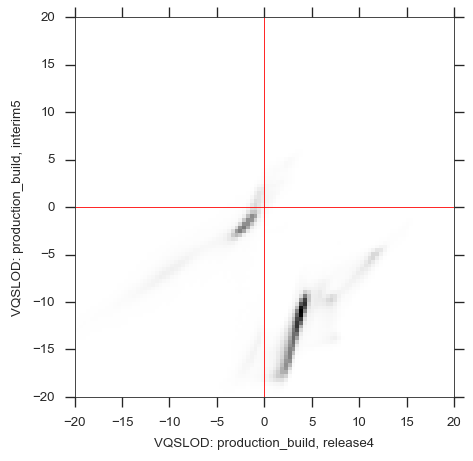

In [29]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1, 1, 1)
vqsr_plot(ax=ax)
fig.tight_layout()
fig.savefig("%s/VQSLOD_release4_vs_interim5_SNP.pdf" % plot_dir)

production_build_indel_4g, release4:  662838/2151500 ( 30.81%) PASS INDELs
production_build_indel_4g, interim5:  739769/2164863 ( 34.17%) PASS INDELs
production_build_indel_4g release4 production_build_indel_4g interim5 2148474 2148474 661391 735919 525269


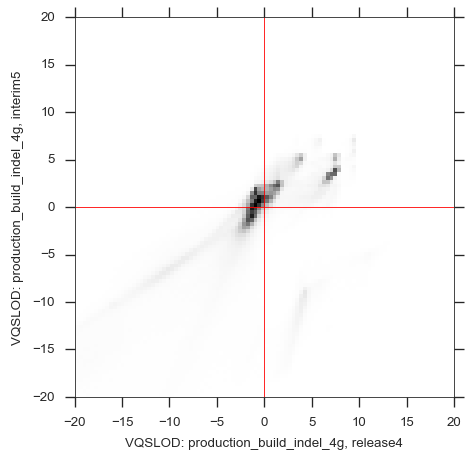

In [39]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1, 1, 1)
vqsr_plot(run_names=['production_build_indel_4g', 'production_build_indel_4g'], mode='INDEL', ax=ax)
fig.tight_layout()
fig.savefig("%s/VQSLOD_release4_vs_interim5_INDEL.pdf" % plot_dir)

production_build, release4:  686041/2151500 ( 31.89%) PASS INDELs
production_build, interim5:  654632/2164863 ( 30.24%) PASS INDELs
production_build release4 production_build interim5 2148474 2148474 684614 651194 535187


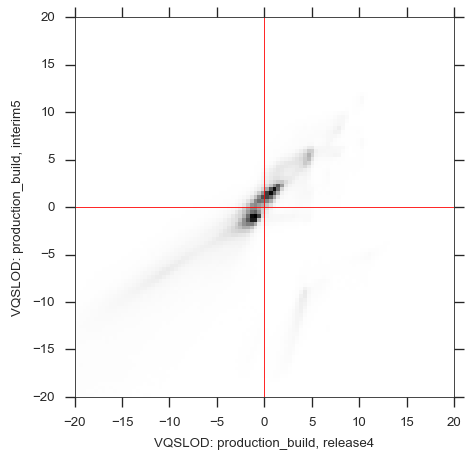

In [19]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1, 1, 1)
vqsr_plot(mode='INDEL', ax=ax)
fig.tight_layout()
fig.savefig("%s/VQSLOD_release4_vs_interim5.pdf" % plot_dir)


production_build release4 production_build interim5 2043220 2043220

production_build release4 odd_chromosomes release4 2049376 2049376

production_build release4 odd_chromosomes interim5 2043220 2043220

production_build interim5 odd_chromosomes release4 2043220 2043220

production_build interim5 odd_chromosomes interim5 2047602 2047602

odd_chromosomes release4 odd_chromosomes interim5 2043220 2043220


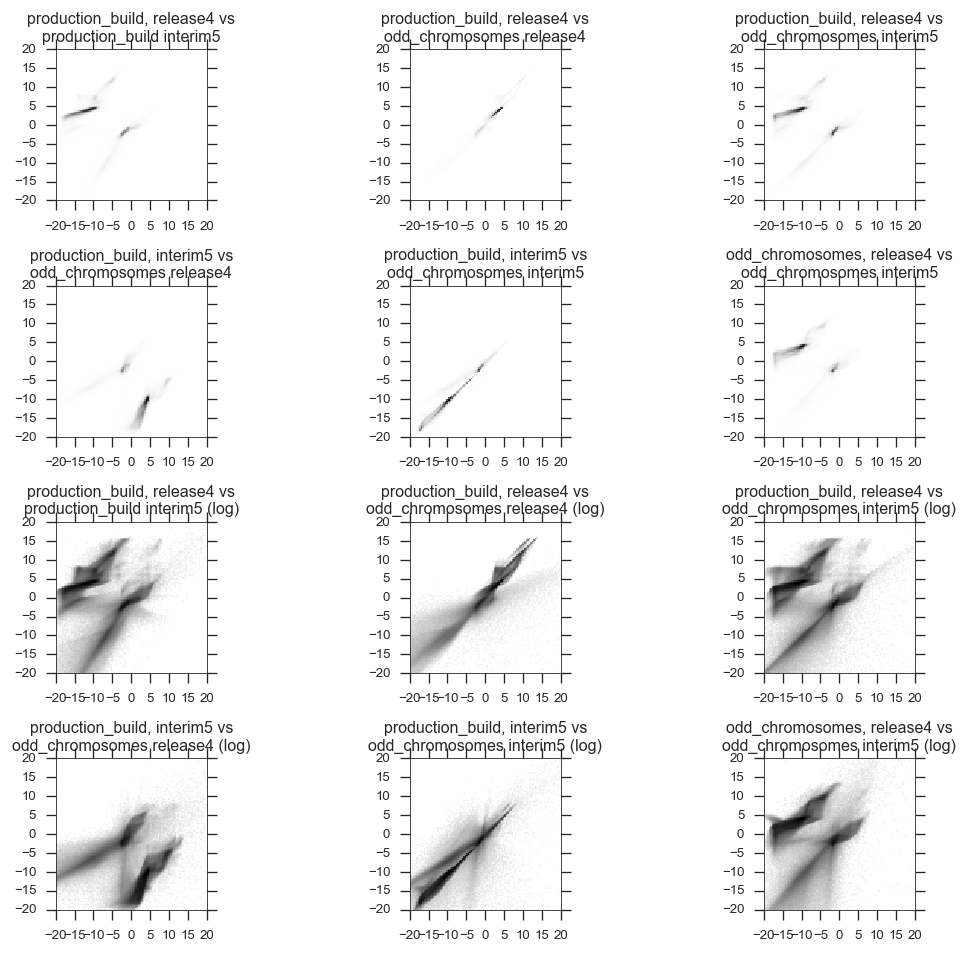

In [57]:
vqsr_plots()

production_build, release4: 1299521/2049376 ( 63.41%) PASS SNPs
production_build, interim5:  110210/2047602 (  5.38%) PASS SNPs
no_ranksum, release4: 1445961/2049376 ( 70.56%) PASS SNPs
no_ranksum, interim5: 1121982/2047602 ( 54.79%) PASS SNPs

production_build release4 production_build interim5 2043220 2043220 1298629 109921 49350
production_build release4 no_ranksum release4 2049376 2049376 1299521 1445961 1288302
production_build release4 no_ranksum interim5 2043220 2043220 1298629 1120917 1018929
production_build interim5 no_ranksum release4 2043220 2043220 109921 1444712 86377
production_build interim5 no_ranksum interim5 2047602 2047602 110210 1121982 90854
no_ranksum release4 no_ranksum interim5 2043220 2043220 1444712 1120917 1108911


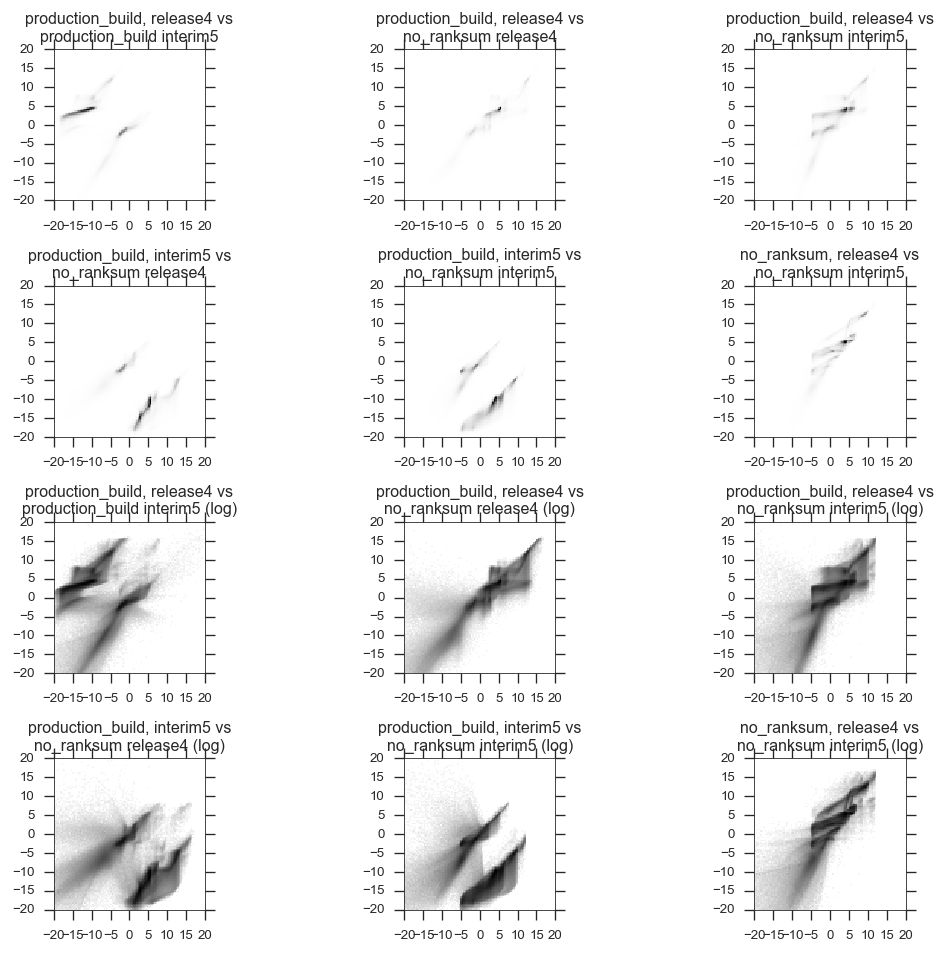

In [91]:
vqsr_plots(['production_build', 'no_ranksum'])

In [167]:
vqsr_experiments.keys()

odict_keys(['production_build', 'odd_chromosomes', 'no_ranksum', 'no_MQRankSum', 'no_ReadPosRankSum', 'no_FS', 'no_MQ', 'no_ranksum_MQ', 'no_ranksum_fs_4gaussians', 'gatk_3_5', 'no_ranksum_3_5', 'no_ranksum_3_5_mqcap70', '4_gaussians', 'vqsr_prior_5', 'release4_hard_filtered_stringent', 'interim5_hard_filtered_gatkrec', 'interim5_hard_filtered_stringent'])

production_build, release4: 1299521/2049376 ( 63.41%) PASS SNPs
production_build, interim5:  110210/2047602 (  5.38%) PASS SNPs
no_ranksum_MQ, release4: 1086901/2049376 ( 53.04%) PASS SNPs
no_ranksum_MQ, interim5:  873082/2047602 ( 42.64%) PASS SNPs

production_build release4 production_build interim5 2043220 2043220 1298629 109921 49350
production_build release4 no_ranksum_MQ release4 2049376 2049376 1299521 1086901 956357
production_build release4 no_ranksum_MQ interim5 2043220 2043220 1298629 872097 782506
production_build interim5 no_ranksum_MQ release4 2043220 2043220 109921 1086268 93252
production_build interim5 no_ranksum_MQ interim5 2047602 2047602 110210 873082 89437
no_ranksum_MQ release4 no_ranksum_MQ interim5 2043220 2043220 1086268 872097 868345
production_build, release4: 1299521/2049376 ( 63.41%) PASS SNPs
production_build, interim5:  110210/2047602 (  5.38%) PASS SNPs
no_ranksum_3_5, release4: 1419410/2049376 ( 69.26%) PASS SNPs
no_ranksum_3_5, interim5: 1068394/204760

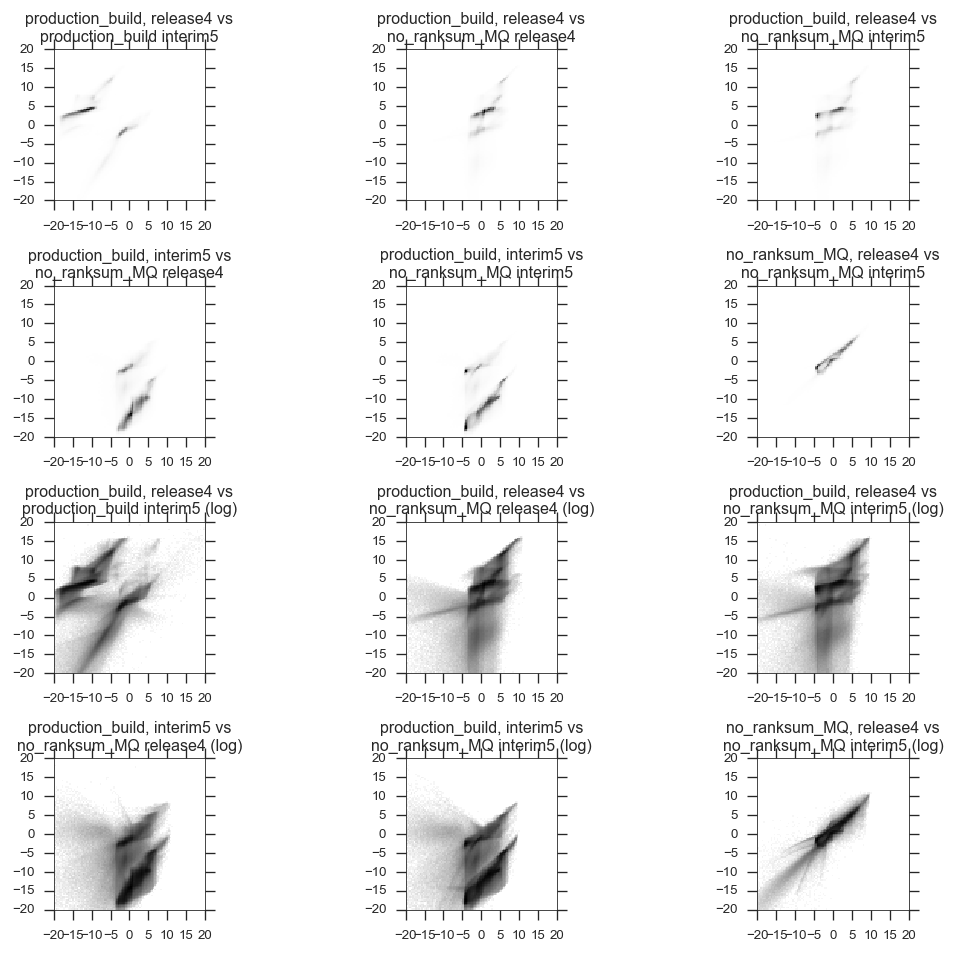

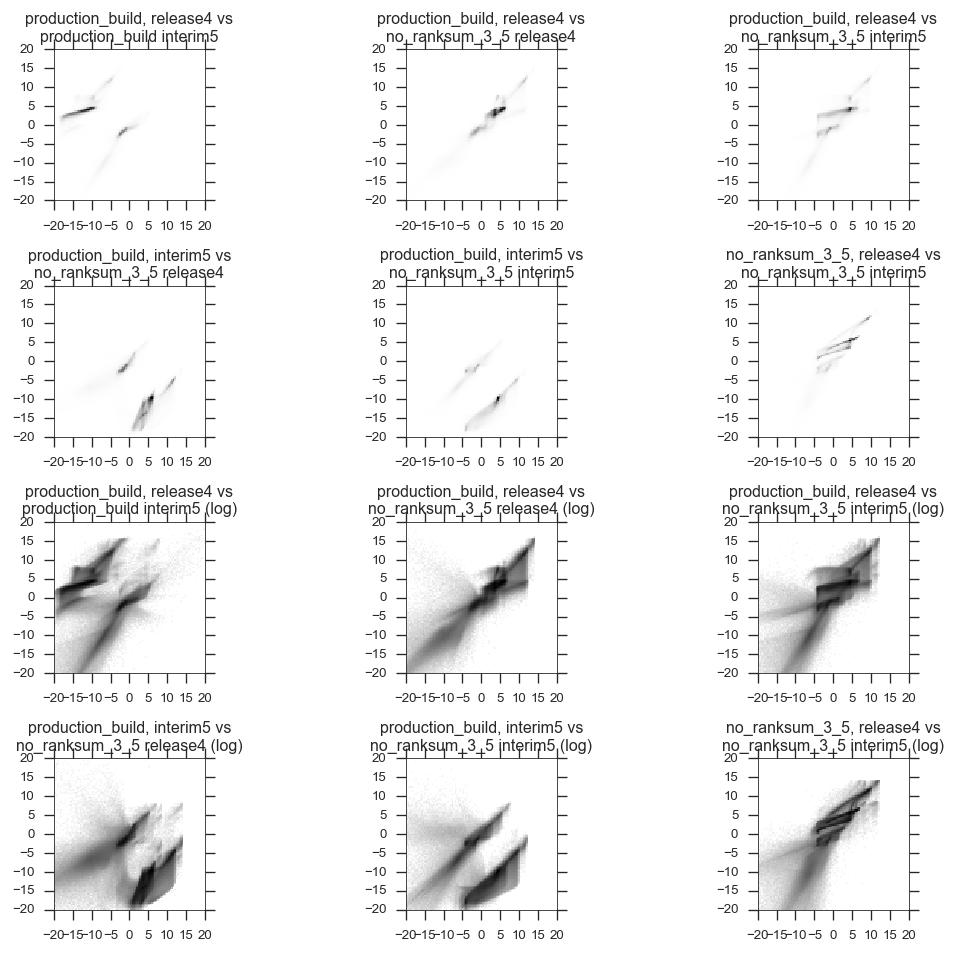

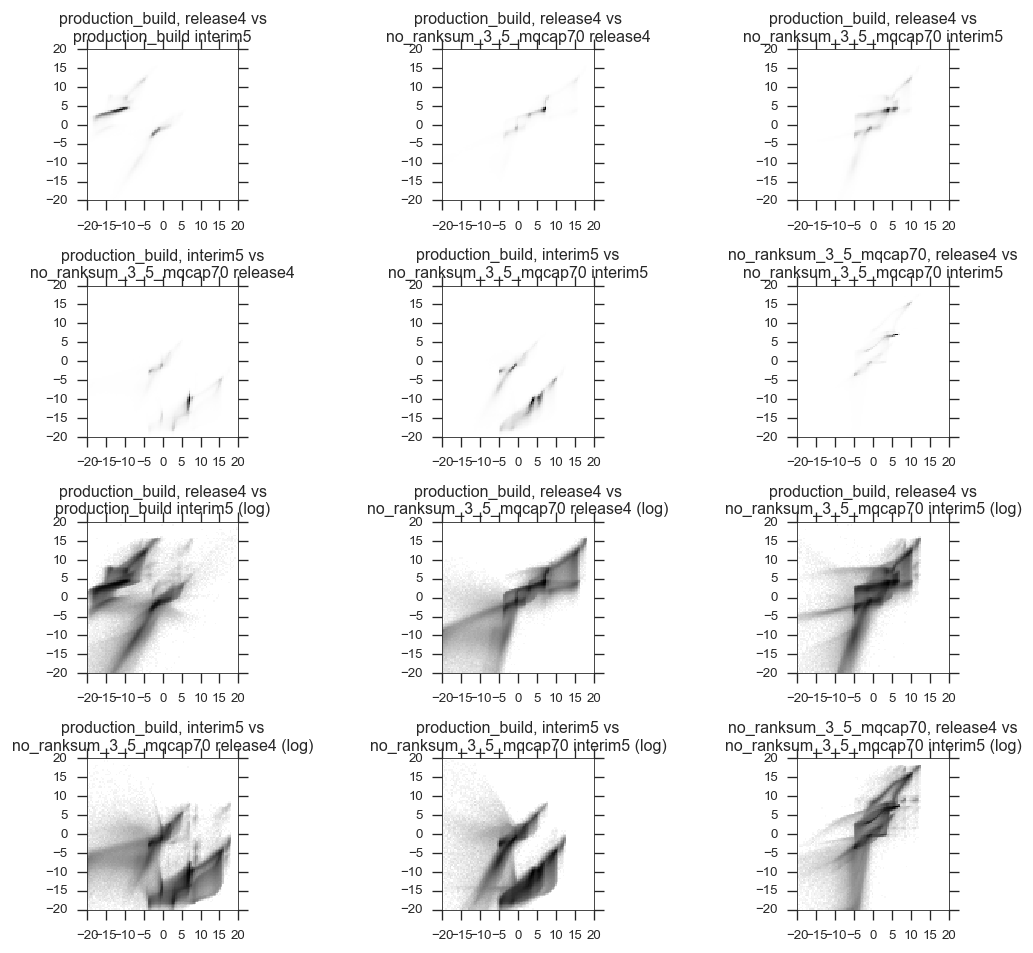

In [168]:
for vqsr_experiment in ['no_ranksum_MQ', 'no_ranksum_3_5', 'no_ranksum_3_5_mqcap70']:
    vqsr_plots(['production_build', vqsr_experiment])

production_build, release4: 1299521/2049376 ( 63.41%) PASS SNPs
production_build, interim5:  110210/2047602 (  5.38%) PASS SNPs
production_build, release4: 1299521/2049376 ( 63.41%) PASS SNPs
production_build, interim5:  110210/2047602 (  5.38%) PASS SNPs

production_build release4 production_build interim5 2043220 2043220 1298629 109921 49350
production_build release4 production_build release4 2049376 2049376 1299521 1299521 1299521
production_build release4 production_build interim5 2043220 2043220 1298629 109921 49350
production_build interim5 production_build release4 2043220 2043220 109921 1298629 49350
production_build interim5 production_build interim5 2047602 2047602 110210 110210 110210
production_build release4 production_build interim5 2043220 2043220 1298629 109921 49350
production_build, release4: 1299521/2049376 ( 63.41%) PASS SNPs
production_build, interim5:  110210/2047602 (  5.38%) PASS SNPs
odd_chromosomes, release4: 1309910/2049376 ( 63.92%) PASS SNPs
odd_chromosomes

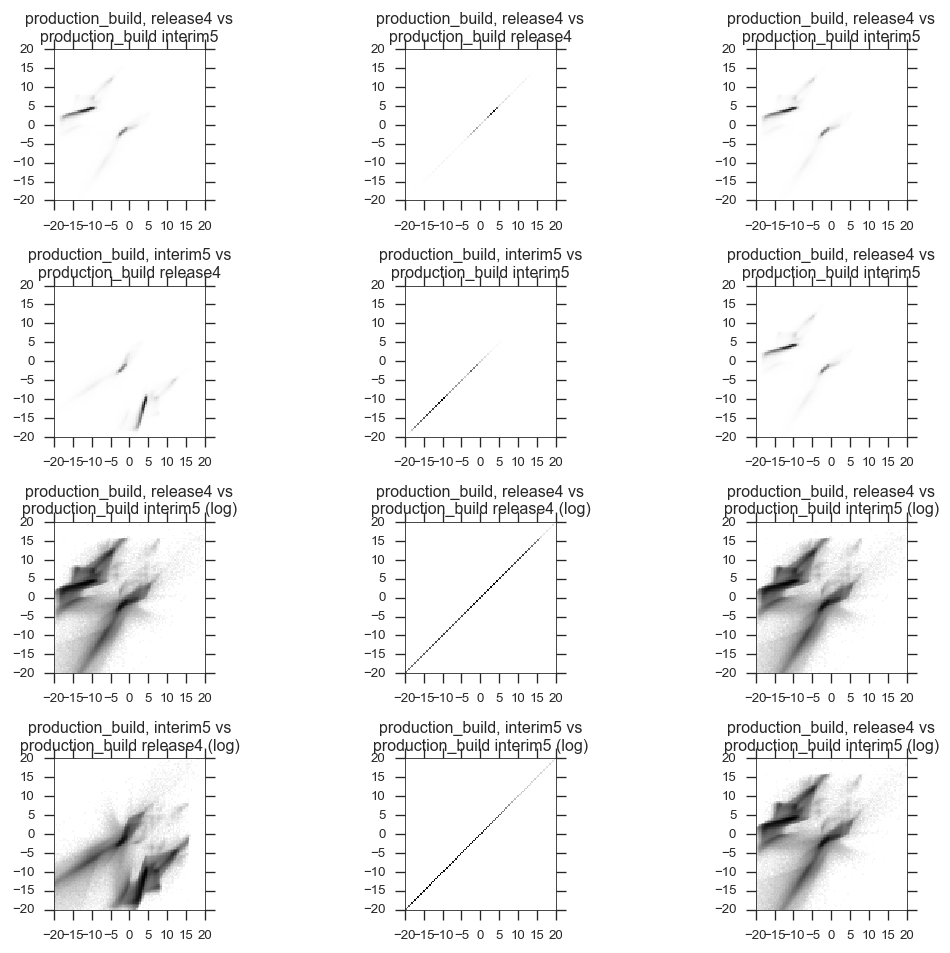

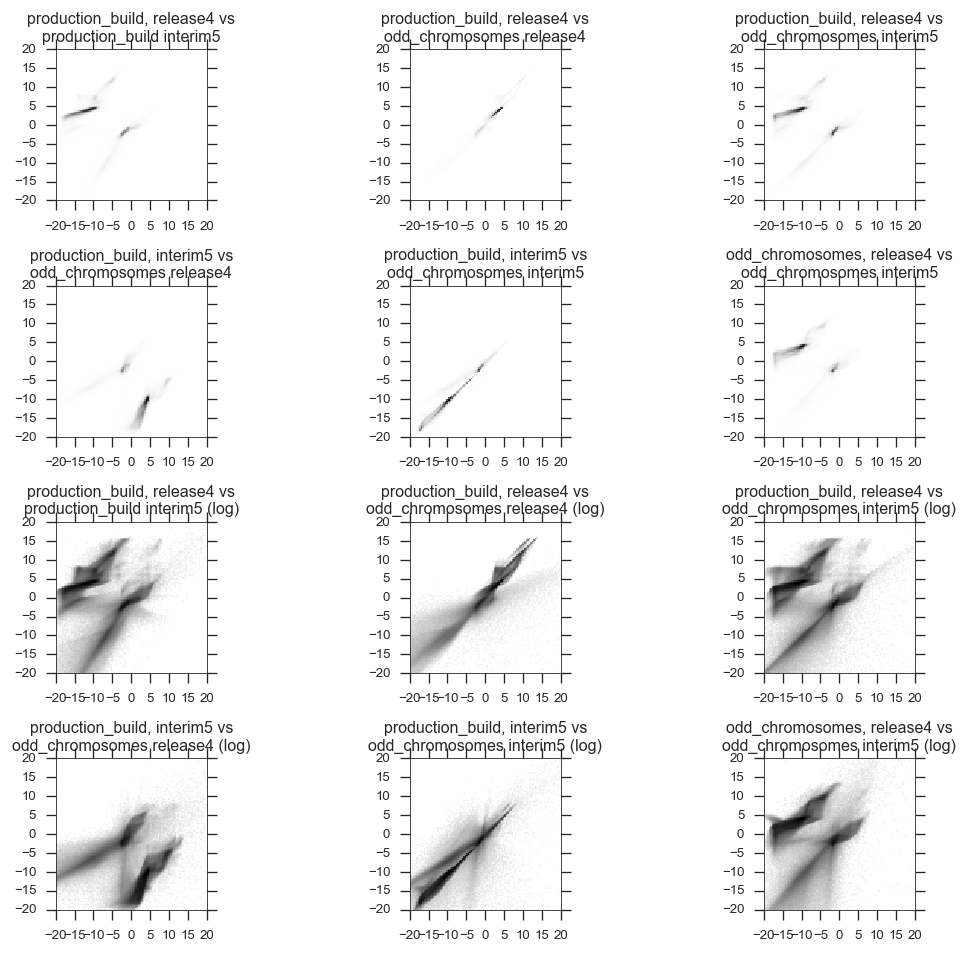

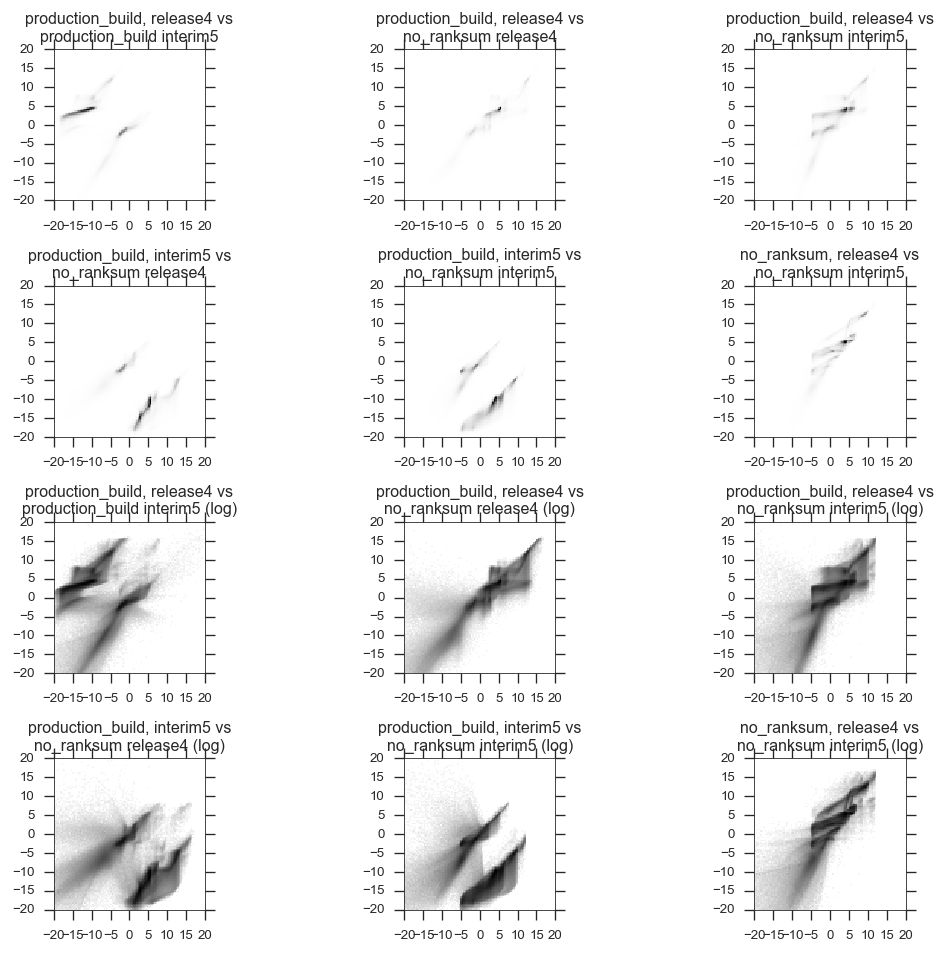

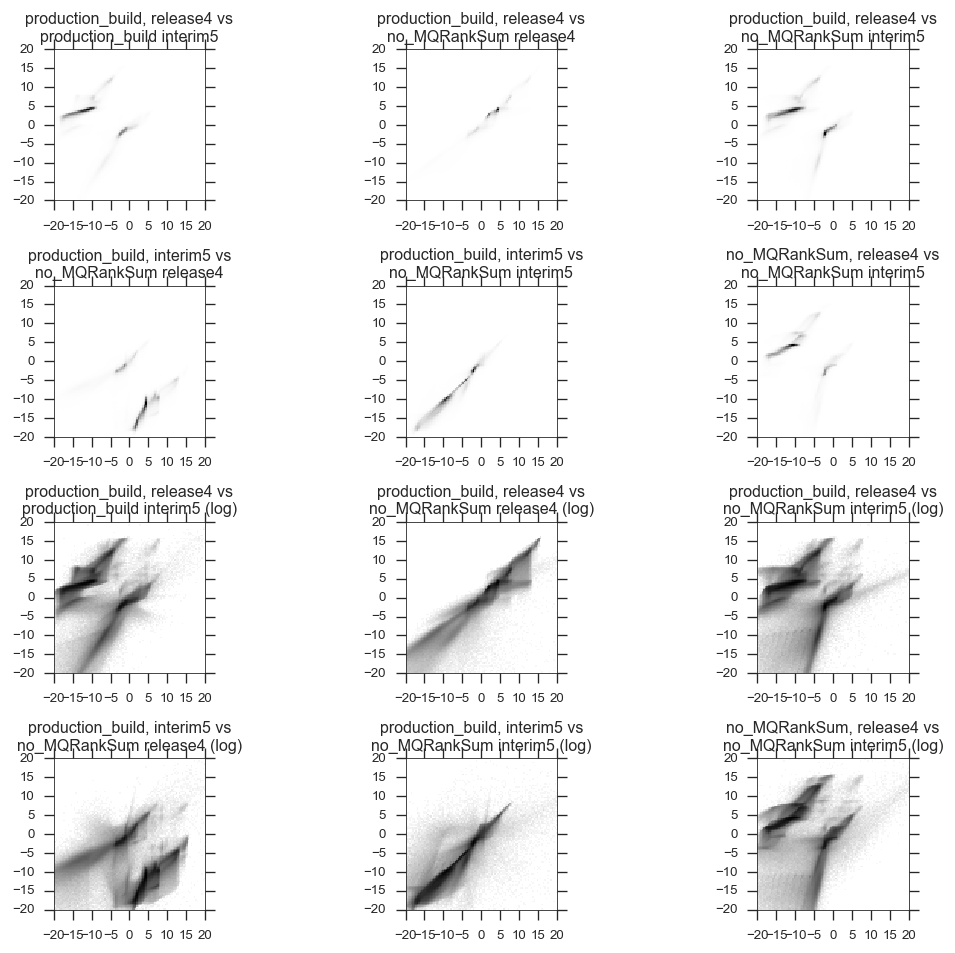

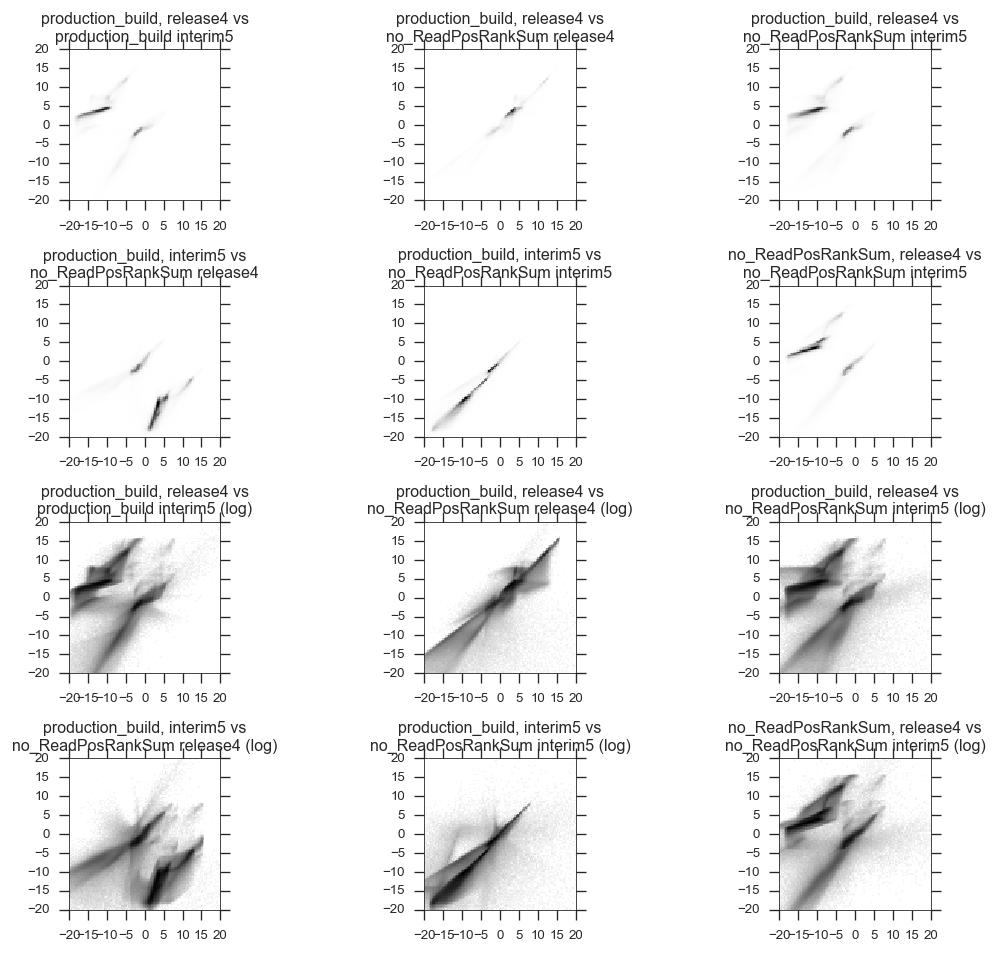

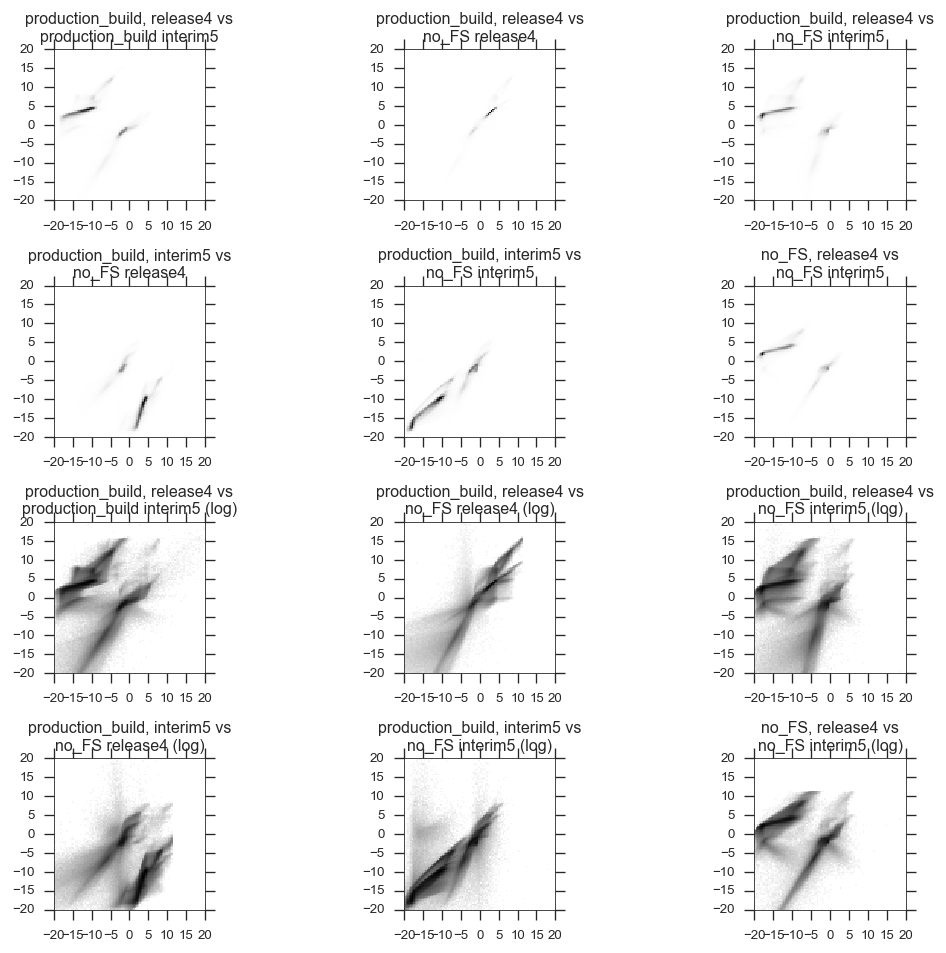

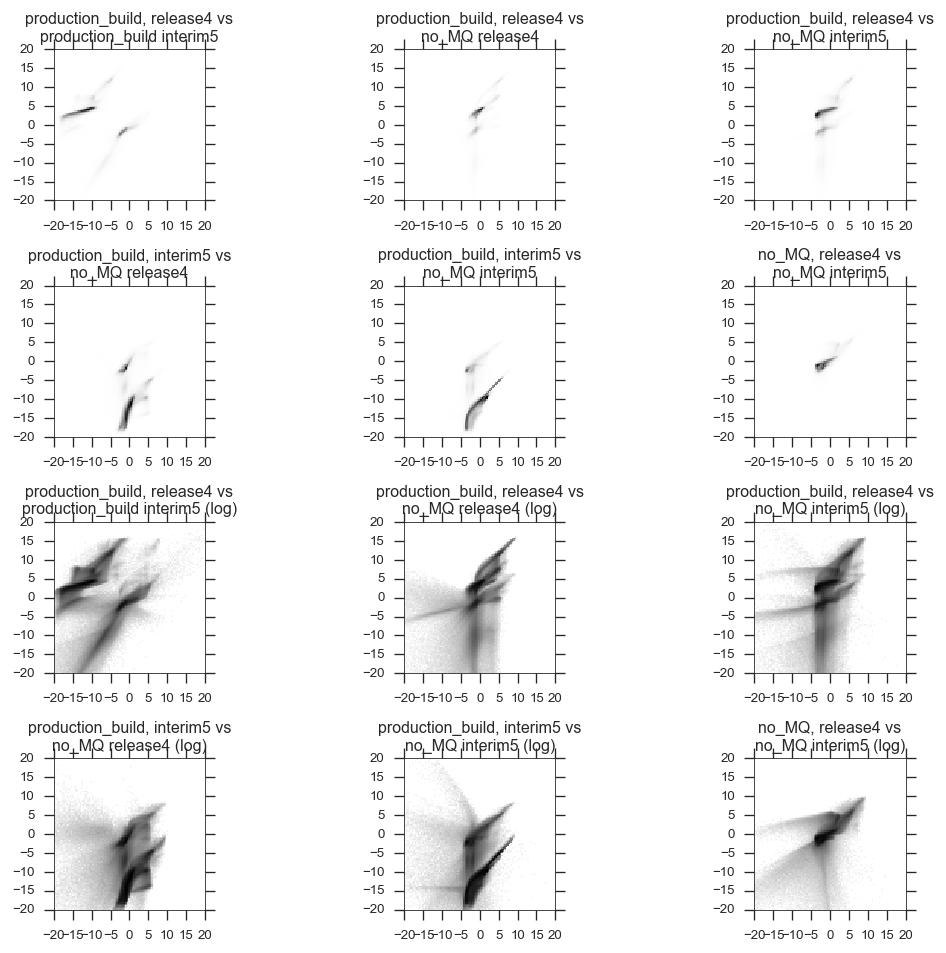

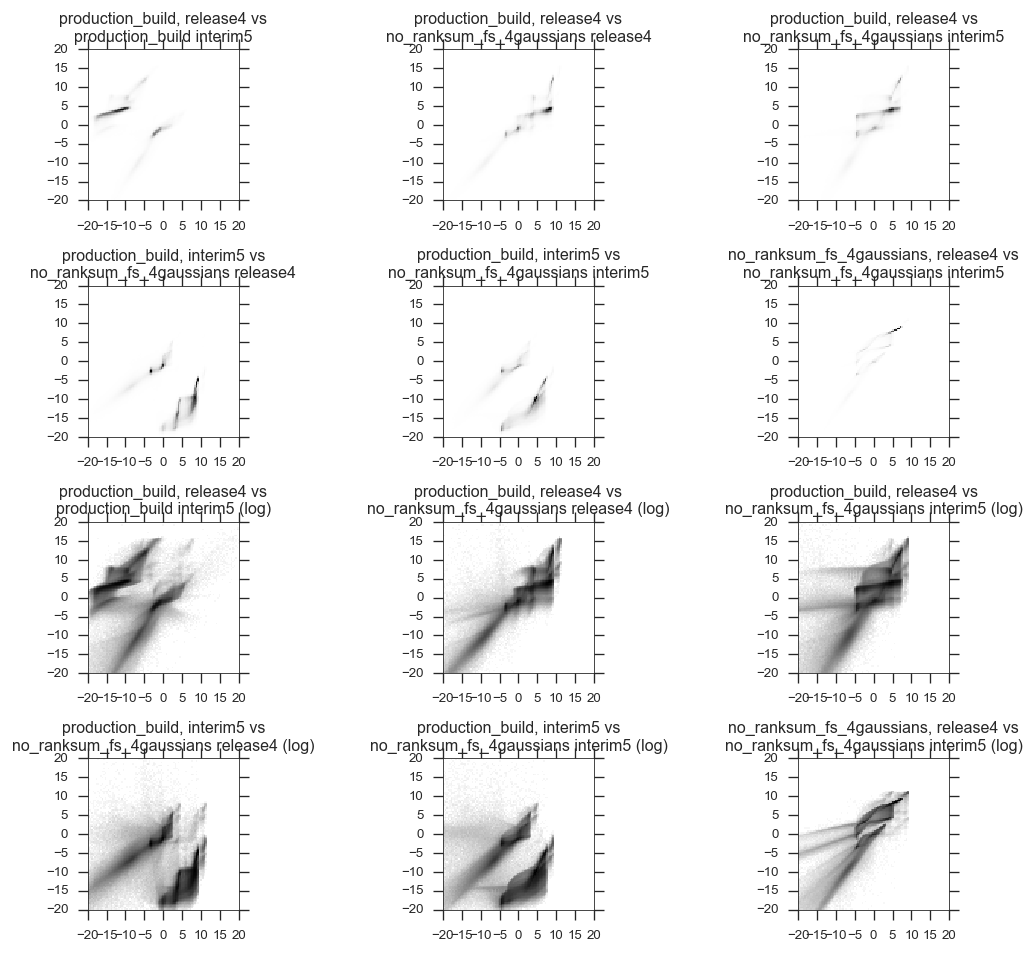

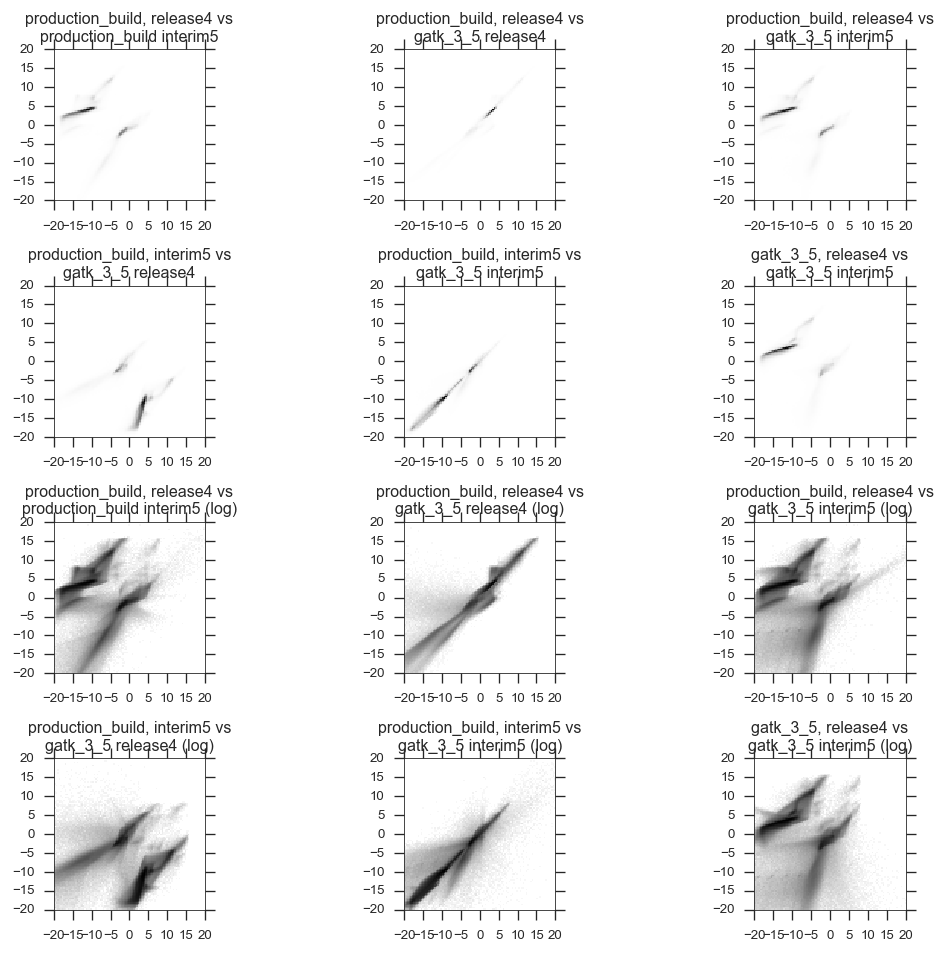

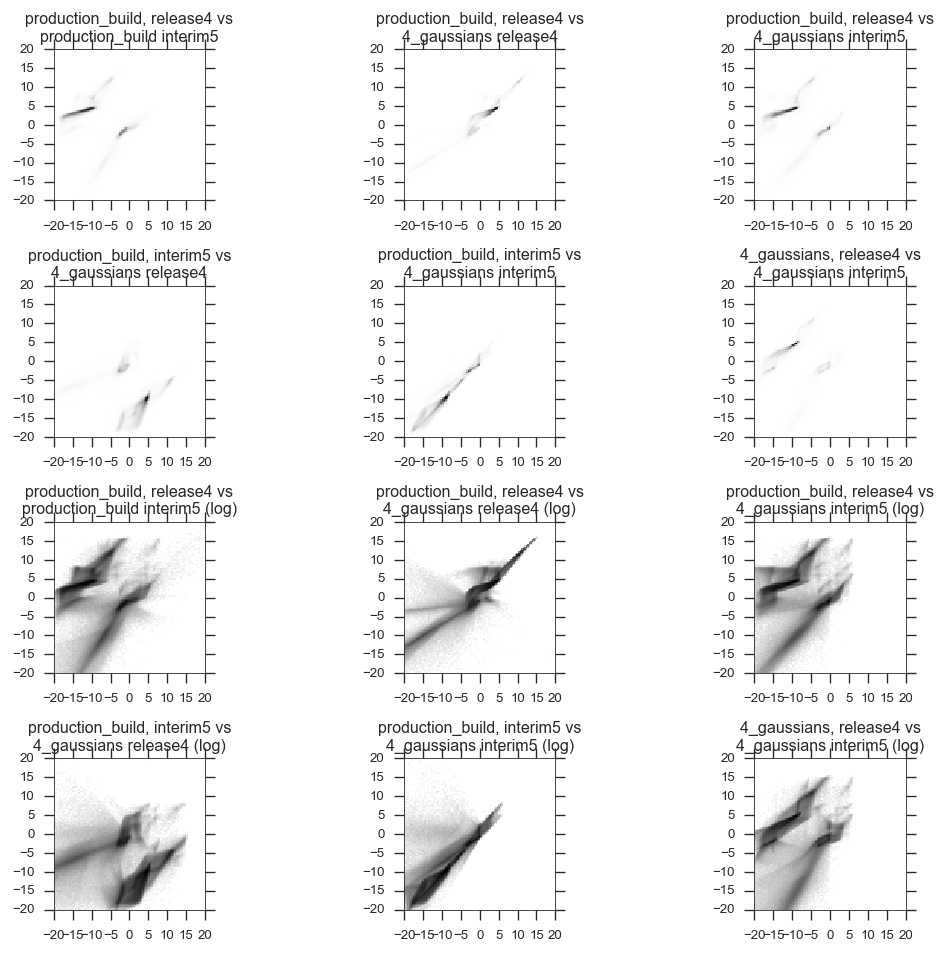

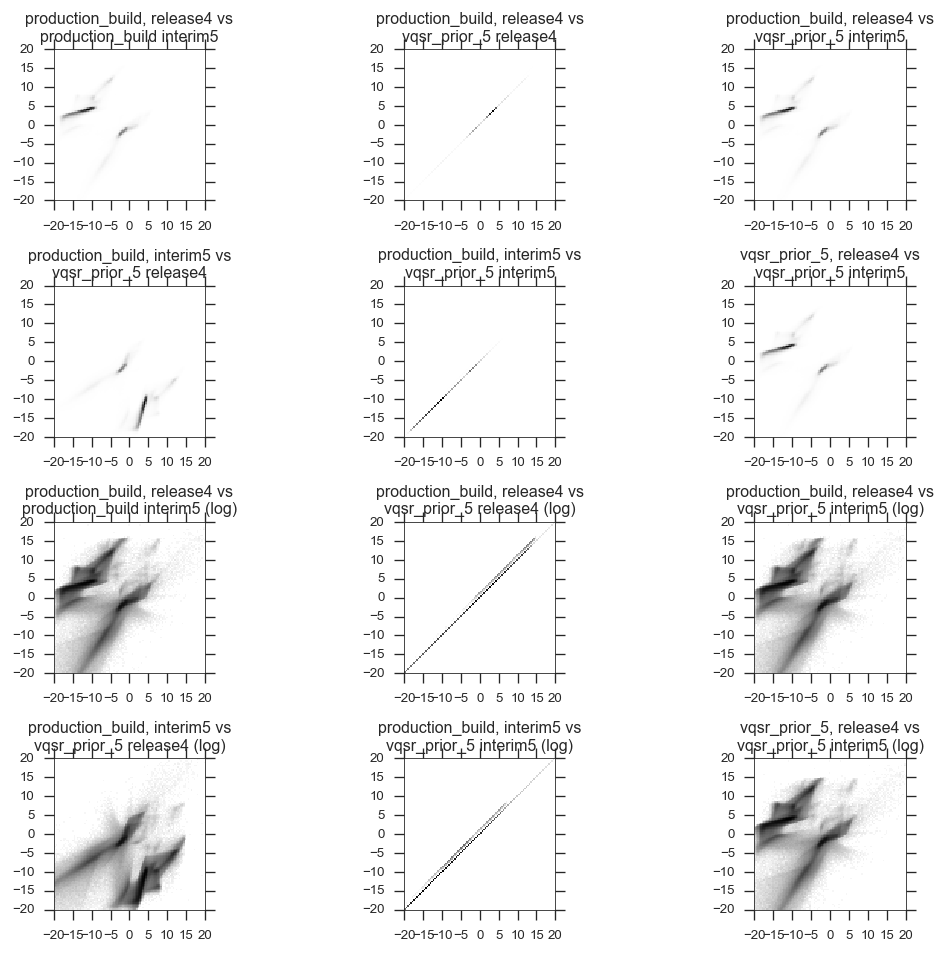

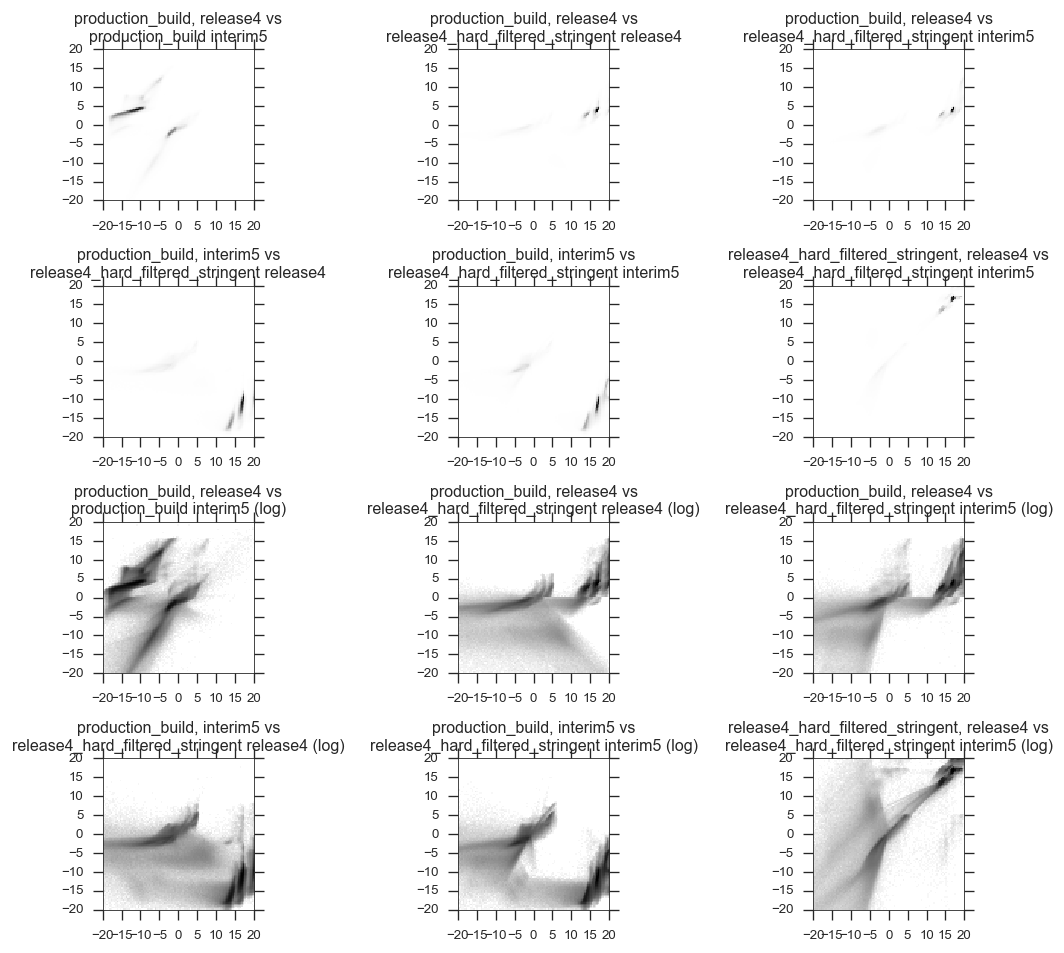

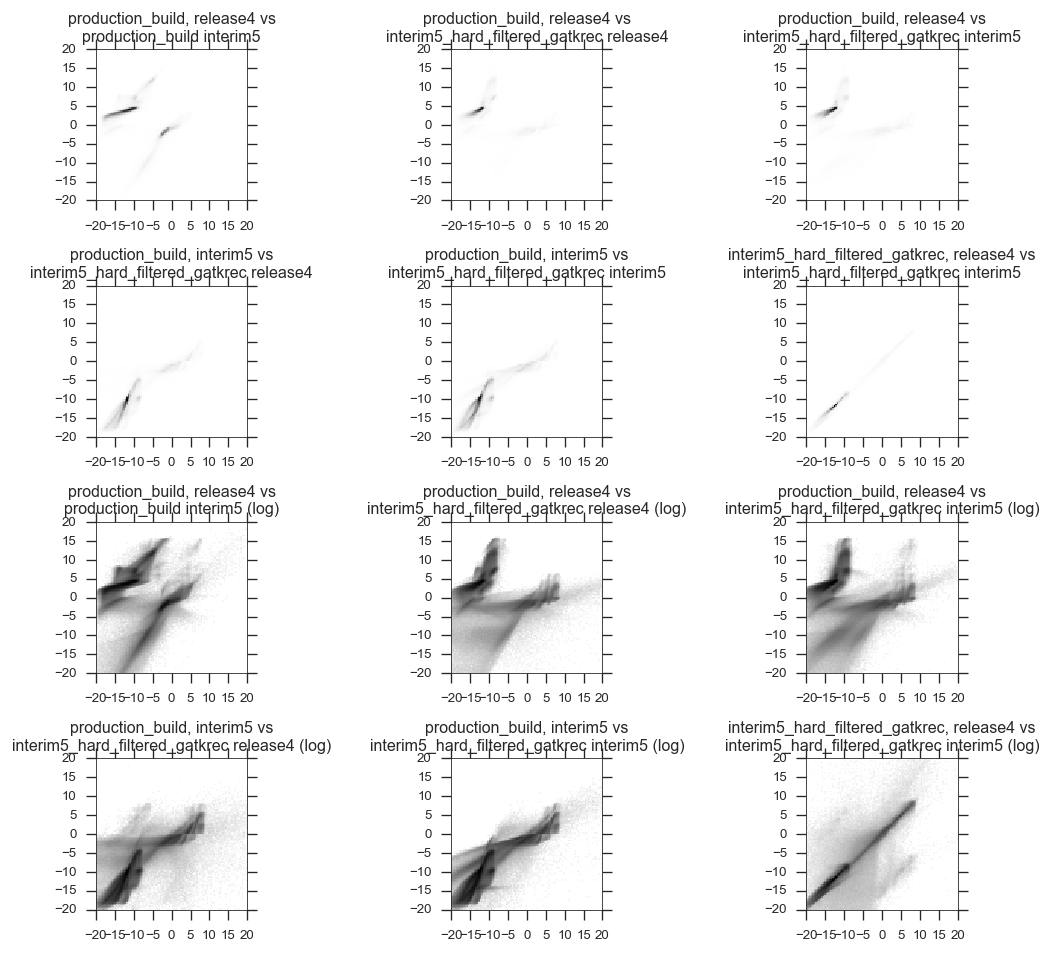

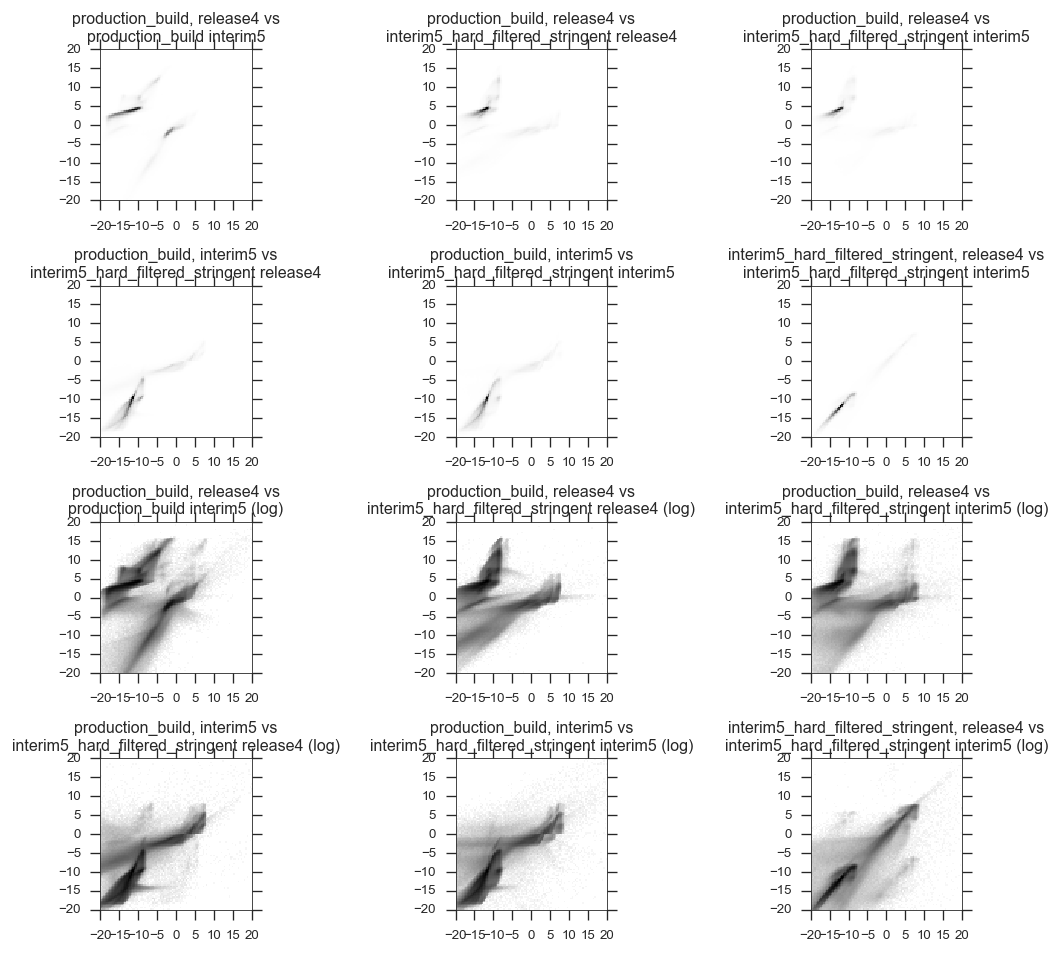

In [157]:
for vqsr_experiment in vqsr_experiments:
    vqsr_plots(['production_build', vqsr_experiment])

production_build, release4: 1299521/2049376 ( 63.41%) PASS SNPs
production_build, interim5:  110210/2047602 (  5.38%) PASS SNPs
no_MQRankSum, release4: 1391074/2049376 ( 67.88%) PASS SNPs
no_MQRankSum, interim5:  111475/2047602 (  5.44%) PASS SNPs

production_build release4 production_build interim5 2043220 2043220 1298629 109921 49350
production_build release4 no_MQRankSum release4 2049376 2049376 1299521 1391074 1295621
production_build release4 no_MQRankSum interim5 2043220 2043220 1298629 111191 49094
production_build interim5 no_MQRankSum release4 2043220 2043220 109921 1390038 84402
production_build interim5 no_MQRankSum interim5 2047602 2047602 110210 111475 87407
no_MQRankSum release4 no_MQRankSum interim5 2043220 2043220 1390038 111191 82138
production_build, release4: 1299521/2049376 ( 63.41%) PASS SNPs
production_build, interim5:  110210/2047602 (  5.38%) PASS SNPs
no_ReadPosRankSum, release4: 1400968/2049376 ( 68.36%) PASS SNPs
no_ReadPosRankSum, interim5:  108104/2047602 (

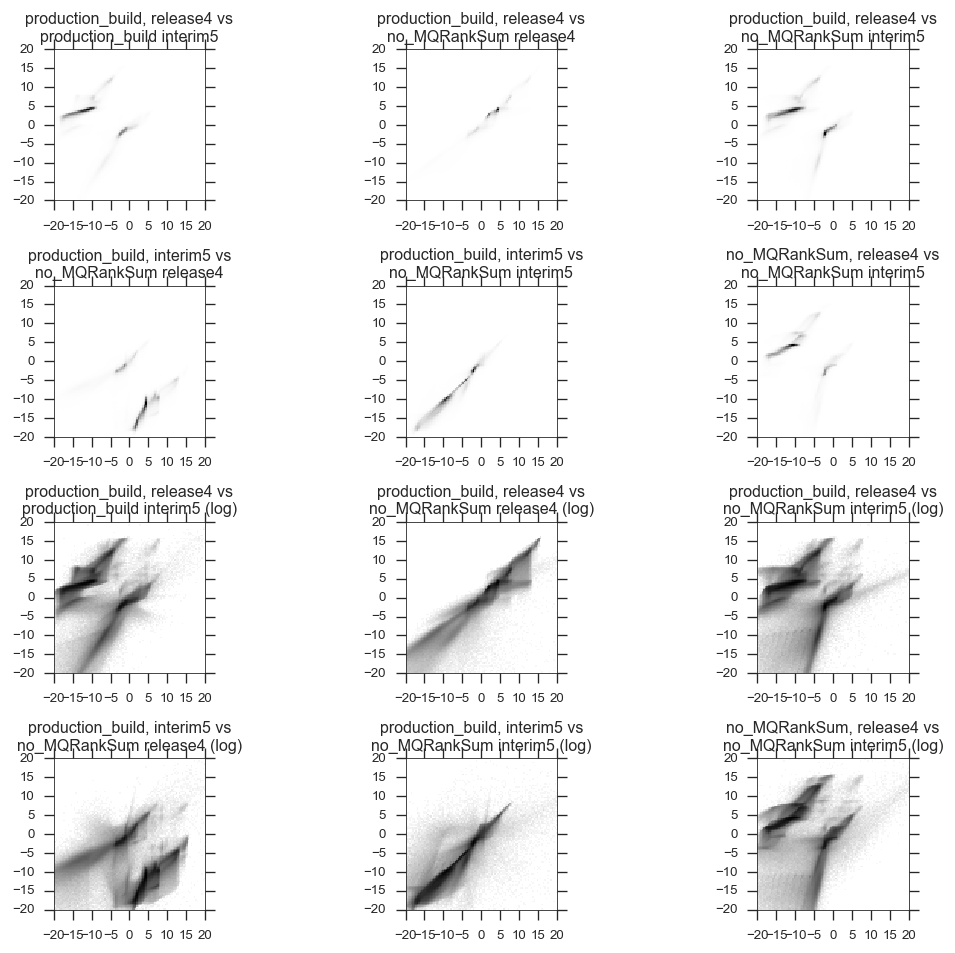

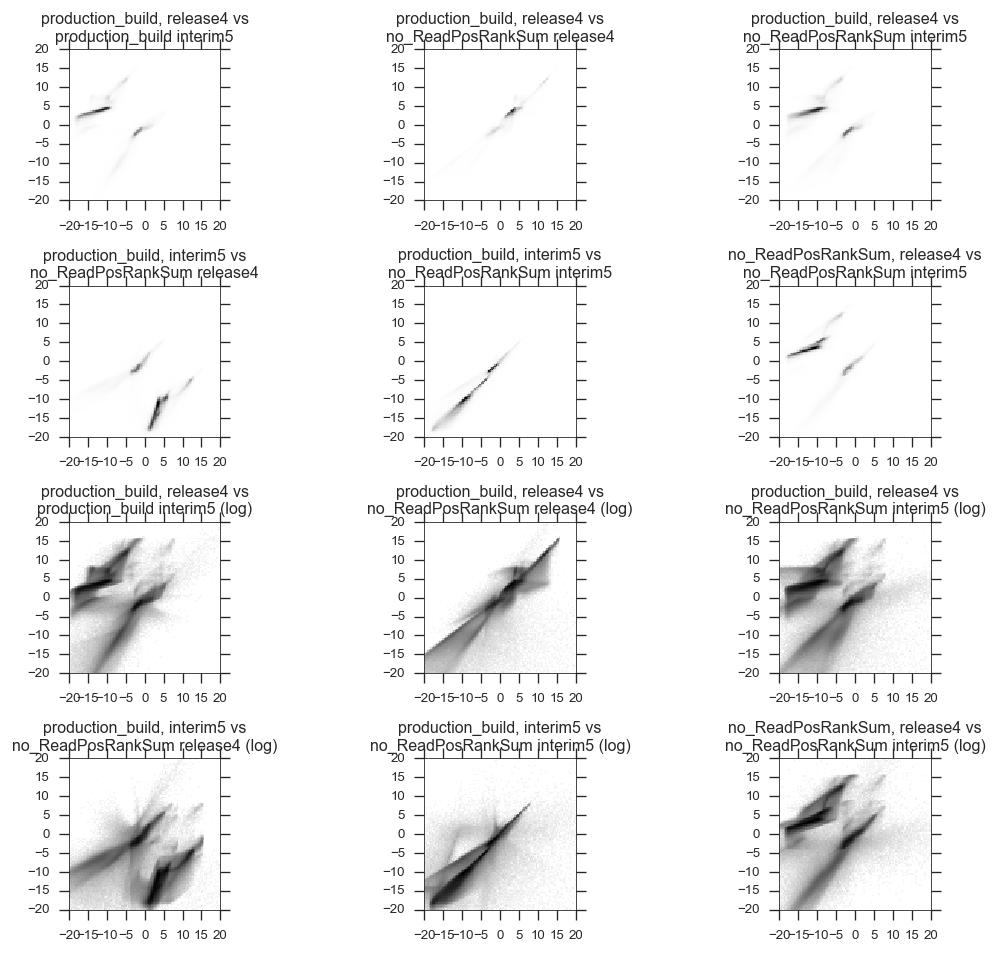

In [112]:
for vqsr_experiment in ['no_MQRankSum', 'no_ReadPosRankSum']:
    vqsr_plots(['production_build', vqsr_experiment])

In [19]:
def pass_pct(
    run_name='production_build', releases=['release4', 'interim5']
):
    vqslod = collections.OrderedDict()
    pass_snps_pct = collections.OrderedDict()
    for release in releases:
        npy_fn = os.path.join(DATA_DIR, release, 'vqsr', run_name, '%s_WG_sites.filtered.vcf.gz.vcfnp_cache' % release, 'variants.npy')
        vqslod[release] = np.load(npy_fn)[['CHROM', 'POS', 'is_snp', 'RegionType', 'VQSLOD']]
        num_snps = np.sum((vqslod[release]['is_snp']))
        num_pass_snps = np.sum(
            (vqslod[release]['is_snp']) &
            (vqslod[release]['RegionType'] == b'Core') &
            (vqslod[release]['VQSLOD'] > 0.0)
        )
        pass_snps_pct[release] = 100.0*num_pass_snps/num_snps
    
    return(pass_snps_pct)
            

In [18]:
pass_pct()

+-----+-----+-----+-----+-----+-----+-----+-----+
| r   | e   | l   | e   | a   | s   | e   | 4   |
+=====+=====+=====+=====+=====+=====+=====+=====+
| 'i' | 'n' | 't' | 'e' | 'r' | 'i' | 'm' | '5' |
+-----+-----+-----+-----+-----+-----+-----+-----+

In [22]:
list(vqsr_experiments.keys())

['production_build',
 'odd_chromosomes',
 'no_ranksum',
 'no_MQRankSum',
 'no_ReadPosRankSum',
 'no_FS',
 'no_MQ',
 'no_ranksum_MQ',
 'no_ranksum_fs_4gaussians',
 'gatk_3_5',
 'no_ranksum_3_5',
 'no_ranksum_3_5_mqcap70',
 '4_gaussians',
 'vqsr_prior_5',
 'release4_hard_filtered_stringent',
 'interim5_hard_filtered_gatkrec',
 'interim5_hard_filtered_stringent']

In [31]:
def pass_pct_array(
    run_names=list(vqsr_experiments.keys()), releases=['release4', 'interim5'],
    figsize=(4, 4), bins=np.linspace(-20, 20, 101), ax=None
):
    pass_pct_array = np.zeros(len(run_names), dtype=[('run_name', 'a40'),
                                                          ('release4_SNP', 'f4'), ('interim5_SNP', 'f4'),
                                                          ('release4_INDEL', 'f4'), ('interim5_INDEL', 'f4'),
                                                         ])
    for i, run_name in enumerate(run_names):
        pass_pct_array[i]['run_name'] = run_name
        for release in releases:
            npy_fn = os.path.join(DATA_DIR, release, 'vqsr', run_name, '%s_WG_sites.SNP.filtered.vcf.gz.vcfnp_cache' % release, 'variants.npy')
            vqslod = np.load(npy_fn)[['CHROM', 'POS', 'is_snp', 'RegionType', 'VQSLOD']]
            num_snps = np.sum((vqslod['is_snp']))
            num_pass_snps = np.sum(
                (vqslod['is_snp']) &
                (vqslod['RegionType'] == b'Core') &
                (vqslod['VQSLOD'] > 0.0)
            )
            pct_pass_snps = num_pass_snps/num_snps
            npy_fn = os.path.join(DATA_DIR, release, 'vqsr', run_name, '%s_WG_sites.INDEL.filtered.vcf.gz.vcfnp_cache' % release, 'variants.npy')
            vqslod = np.load(npy_fn)[['CHROM', 'POS', 'is_snp', 'RegionType', 'VQSLOD']]
            num_indels = np.sum(np.logical_not(vqslod['is_snp']))
            num_pass_indels = np.sum(
                np.logical_not(vqslod['is_snp']) &
                (vqslod['RegionType'] == b'Core') &
                (vqslod['VQSLOD'] > 0.0)
            )
            pct_pass_indels = num_pass_indels/num_indels
            print("%s, %s: %7d/%7d (%6.2f%%) PASS SNPs %7d/%7d (%6.2f%%) PASS indels" % (
                    run_name, release,
                    num_pass_snps, num_snps, 100.0*num_pass_snps/num_snps,
                    num_pass_indels, num_indels, 100.0*num_pass_indels/num_indels,
                ))
            pass_pct_array[i]["%s_SNP" % release] = pct_pass_snps
            pass_pct_array[i]["%s_INDEL" % release] = pct_pass_indels
    return(pass_pct_array)


In [33]:
pass_variants_pct_array = pass_pct_array(run_names=run_names)

production_build, release4: 1299521/2049376 ( 63.41%) PASS SNPs  686041/2151500 ( 31.89%) PASS indels
production_build, interim5:  110210/2047602 (  5.38%) PASS SNPs  654632/2164863 ( 30.24%) PASS indels
odd_chromosomes, release4: 1309910/2049376 ( 63.92%) PASS SNPs  509262/2151500 ( 23.67%) PASS indels
odd_chromosomes, interim5:  104252/2047602 (  5.09%) PASS SNPs  638123/2164863 ( 29.48%) PASS indels
no_ranksum, release4: 1445961/2049376 ( 70.56%) PASS SNPs  790457/2151500 ( 36.74%) PASS indels
no_ranksum, interim5: 1121982/2047602 ( 54.79%) PASS SNPs  758588/2164863 ( 35.04%) PASS indels
no_MQRankSum, release4: 1391074/2049376 ( 67.88%) PASS SNPs  737278/2151500 ( 34.27%) PASS indels
no_MQRankSum, interim5:  111475/2047602 (  5.44%) PASS SNPs  673659/2164863 ( 31.12%) PASS indels
no_ReadPosRankSum, release4: 1400968/2049376 ( 68.36%) PASS SNPs  709366/2151500 ( 32.97%) PASS indels
no_ReadPosRankSum, interim5:  108104/2047602 (  5.28%) PASS SNPs  661336/2164863 ( 30.55%) PASS indels


In [34]:
etl.fromarray(pass_variants_pct_array).convert('run_name', lambda x: x.decode('ascii')).displayall()

0|run_name 
 1|release4_SNP 
 2|interim5_SNP 
 3|release4_INDEL 
 4|interim5_INDEL 
 
 
 
 
 production_build 
 0.634106 
 0.0538239 
 0.318866 
 0.30239 
 
 
 odd_chromosomes 
 0.639175 
 0.0509142 
 0.236701 
 0.294764 
 
 
 no_ranksum 
 0.705562 
 0.547949 
 0.367398 
 0.350409 
 
 
 no_MQRankSum 
 0.678779 
 0.0544417 
 0.342681 
 0.311179 
 
 
 no_ReadPosRankSum 
 0.683607 
 0.0527954 
 0.329708 
 0.305486 
 
 
 no_ranksum_fs_4gaussians 
 0.688138 
 0.551236 
 0.398567 
 0.366479 
 
 
 no_FS 
 0.640676 
 0.0459201 
 0.285307 
 0.296171 
 
 
 no_MQ 
 0.341977 
 0.277898 
 0.314005 
 0.266579 
 
 
 no_ranksum_MQ 
 0.530357 
 0.426392 
 0.366101 
 0.34104 
 
 
 gatk_3_5 
 0.660004 
 0.056006 
 0.308396 
 0.287918 
 
 
 no_ranksum_3_5 
 0.692606 
 0.521778 
 0.376208 
 0.339648 
 
 
 no_ranksum_3_5_mqcap70 
 0.645471 
 0.551724 
 0.395794 
 0.369049 
 
 
 4_gaussians 
 0.541069 
 0.0322143 
 0.30936 
 0.259881 
 
 
 vqsr_prior_5 
 0.633814 
 0.0536965 
 0.318185 
 0.301578 
 
 
 gatk_rec_indel 
 0.538678 
 0.443052 
 0.372443 
 0.322359

In [35]:
(etl
    .fromarray(pass_variants_pct_array)
    .convert('run_name', lambda x: x.decode('ascii'))
    .totsv("%s/pass_variants_pct.txt" % plot_dir)
)


In [43]:
def vqsr_plots_all_runs(
    run_names=['production_build', 'delta'], releases=['release4', 'interim5'], mode='SNP',
    figsize=(11, 6), bins=np.linspace(-20, 20, 101)
):

    fig = plt.figure(figsize=figsize)
    
    vqslod = collections.OrderedDict()
    if run_names[0] == 'production_build':
#         vqslod['production_build'] = collections.OrderedDict()
        if mode=='SNP':
            npy_fn = os.path.join(DATA_DIR, releases[0], 'vqsr', 'production_build', '%s_WG_sites.%s.filtered.vcf.gz.vcfnp_cache' % (releases[0], mode), 'variants.npy')
        else:
            npy_fn = os.path.join(DATA_DIR, releases[0], 'vqsr', 'production_build_indel_4g', '%s_WG_sites.%s.filtered.vcf.gz.vcfnp_cache' % (releases[0], mode), 'variants.npy')
        vqslod['production_build'] = np.load(npy_fn)[['CHROM', 'POS', 'is_snp', 'RegionType', 'VQSLOD']]
        releases = [releases[1]]
#     for run_name in list(vqsr_experiments.keys()):
    for run_name in plot_run_names:
        if run_name=='production_build':
            continue
        print("loading data %s" % run_name)
        vqslod[run_name] = collections.OrderedDict()
        for release in releases:
            npy_fn = os.path.join(DATA_DIR, release, 'vqsr', run_name, '%s_WG_sites.%s.filtered.vcf.gz.vcfnp_cache' % (release, mode), 'variants.npy')
            vqslod[run_name][release] = np.load(npy_fn)[['CHROM', 'POS', 'is_snp', 'RegionType', 'VQSLOD']]
    
#     for i, run_name in enumerate(list(vqsr_experiments.keys())):
    for i, run_name in enumerate(plot_run_names):
        if run_name=='production_build':
            continue
        print("creating plot %s" % run_name)
        if run_names[0] == 'production_build':        
            vqslod_first = vqslod['production_build']
            vqslod_second = vqslod[run_name][releases[0]]
        else:
            vqslod_first = vqslod[run_name][releases[0]]
            vqslod_second = vqslod[run_name][releases[1]]
        if mode == 'SNP':
            first_is_this_mode = vqslod_first['is_snp']
            second_is_this_mode = vqslod_second['is_snp']
        else:
            first_is_this_mode = np.logical_not(vqslod_first['is_snp'])
            second_is_this_mode = np.logical_not(vqslod_second['is_snp'])
        snps_first_in_second = (
            np.in1d(
                vqslod_first[['CHROM', 'POS']], vqslod_second[['CHROM', 'POS']][second_is_this_mode]
            ) & first_is_this_mode
        )
        snps_second_in_first = (
            np.in1d(
                vqslod_second[['CHROM', 'POS']], vqslod_first[['CHROM', 'POS']][first_is_this_mode]
            ) & second_is_this_mode
        )
        pass_snps_1 = (
            (first_is_this_mode[snps_first_in_second]) &
            (vqslod_first['RegionType'][snps_first_in_second] == b'Core') &
            (vqslod_first['VQSLOD'][snps_first_in_second] > 0.0)
        )
        pass_snps_2 = (
            (second_is_this_mode[snps_second_in_first]) &
            (vqslod_second['RegionType'][snps_second_in_first] == b'Core') &
            (vqslod_second['VQSLOD'][snps_second_in_first] > 0.0)
        )
        assert pass_snps_1.size == pass_snps_2.size
        pass_snps_intersection = (pass_snps_1 & pass_snps_2)
        
        assert np.sum(snps_first_in_second) == np.sum(snps_second_in_first)
        
        H, xedges, yedges = np.histogram2d(
            vqslod_second['VQSLOD'][snps_second_in_first],
            vqslod_first['VQSLOD'][snps_first_in_second],
            bins=(bins, bins)
        )

        ax = fig.add_subplot(3, 5, i)
        ax.set_title("%s" % (run_name))
        im = plt.imshow(H, interpolation='nearest', origin='low',
                    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
        ax.axvline(0, color='red')
        ax.axhline(0, color='red')

    fig.tight_layout()
    return(fig)
    


loading data odd_chromosomes
loading data no_ranksum
loading data no_MQRankSum
loading data no_ReadPosRankSum
loading data no_ranksum_fs_4gaussians
loading data no_FS
loading data no_MQ
loading data no_ranksum_MQ
loading data gatk_3_5
loading data no_ranksum_3_5
loading data no_ranksum_3_5_mqcap70
loading data 4_gaussians
loading data vqsr_prior_5
loading data gatk_rec_indel
creating plot odd_chromosomes
creating plot no_ranksum
creating plot no_MQRankSum
creating plot no_ReadPosRankSum
creating plot no_ranksum_fs_4gaussians
creating plot no_FS
creating plot no_MQ
creating plot no_ranksum_MQ
creating plot gatk_3_5
creating plot no_ranksum_3_5
creating plot no_ranksum_3_5_mqcap70
creating plot 4_gaussians
creating plot vqsr_prior_5
creating plot gatk_rec_indel


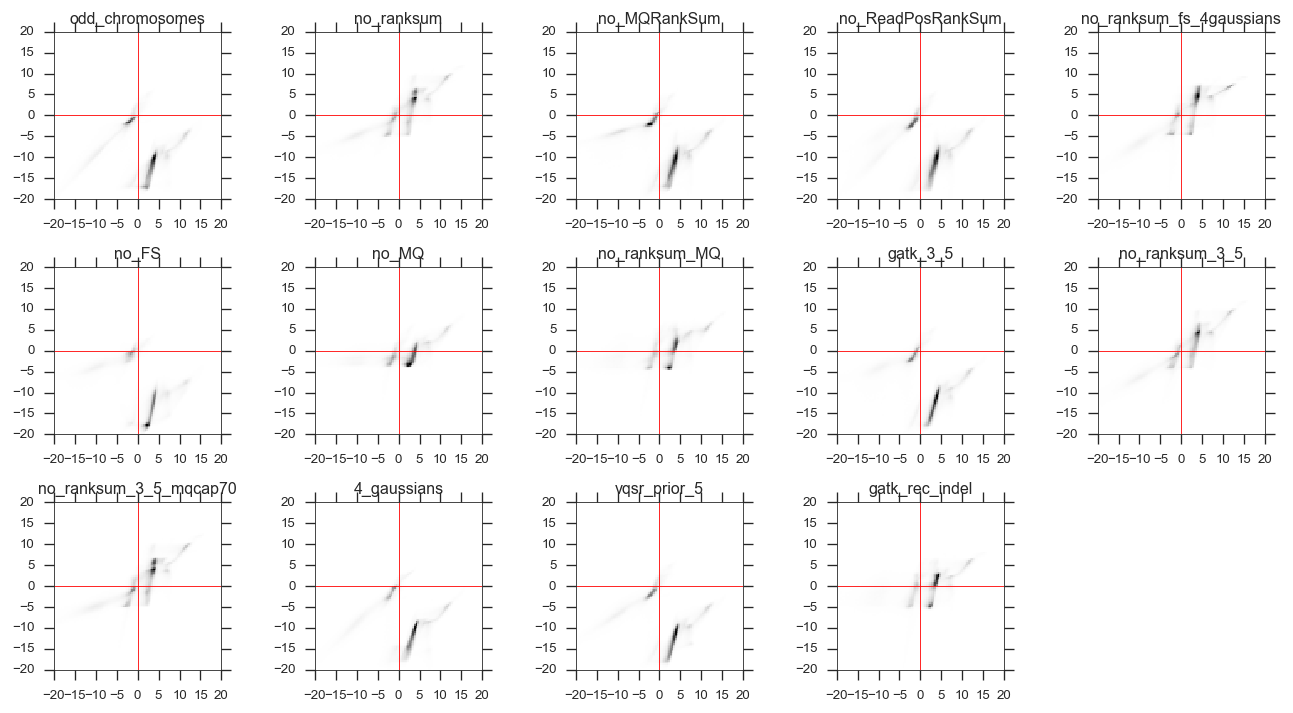

In [44]:
fig=vqsr_plots_all_runs()
fig.savefig("%s/VQSLOD_release4_vs_delta5_SNP.pdf" % plot_dir)

loading data odd_chromosomes
loading data no_ranksum
loading data no_MQRankSum
loading data no_ReadPosRankSum
loading data no_ranksum_fs_4gaussians
loading data no_FS
loading data no_MQ
loading data no_ranksum_MQ
loading data gatk_3_5
loading data no_ranksum_3_5
loading data no_ranksum_3_5_mqcap70
loading data 4_gaussians
loading data vqsr_prior_5
loading data gatk_rec_indel
creating plot odd_chromosomes
creating plot no_ranksum
creating plot no_MQRankSum
creating plot no_ReadPosRankSum
creating plot no_ranksum_fs_4gaussians
creating plot no_FS
creating plot no_MQ
creating plot no_ranksum_MQ
creating plot gatk_3_5
creating plot no_ranksum_3_5
creating plot no_ranksum_3_5_mqcap70
creating plot 4_gaussians
creating plot vqsr_prior_5
creating plot gatk_rec_indel


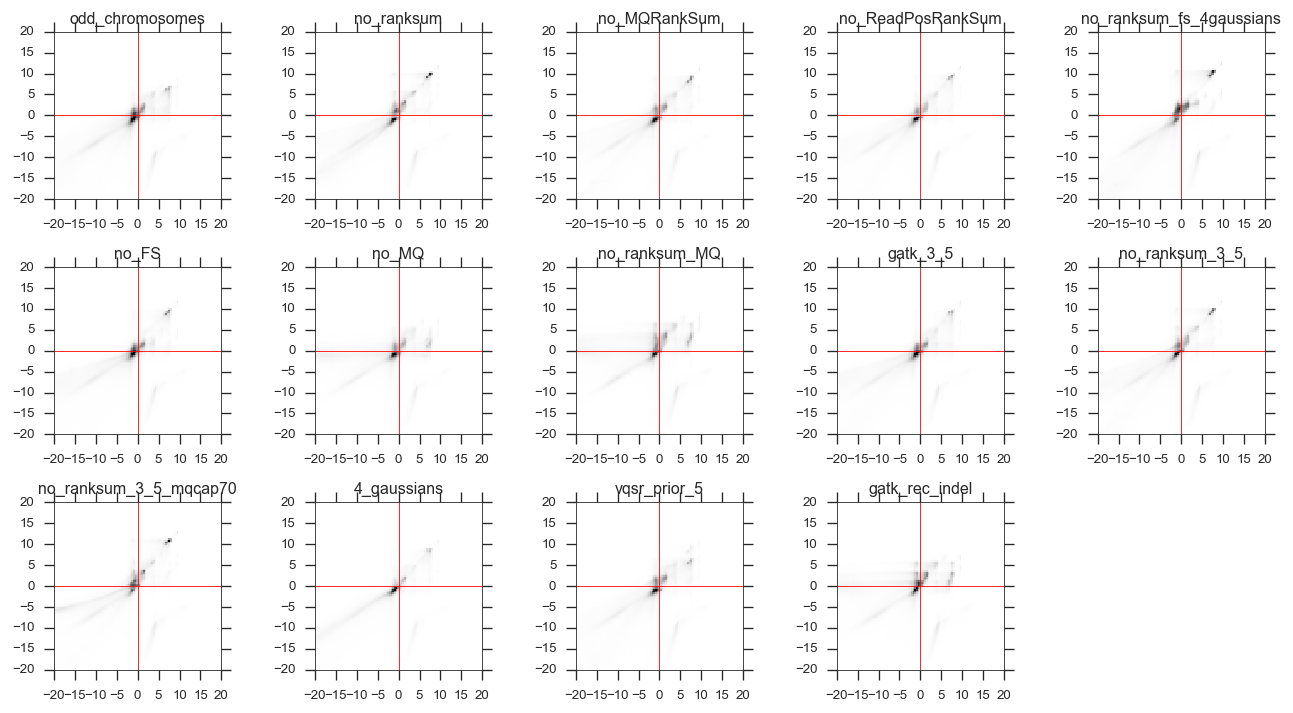

In [45]:
fig_indel=vqsr_plots_all_runs(mode='INDEL')
fig_indel.savefig("%s/VQSLOD_release4_vs_delta5_INDEL.pdf" % plot_dir)

loading data odd_chromosomes
loading data no_ranksum
loading data no_MQRankSum
loading data no_ReadPosRankSum
loading data no_ranksum_fs_4gaussians
loading data no_FS
loading data no_MQ
loading data no_ranksum_MQ
loading data gatk_3_5
loading data no_ranksum_3_5
loading data no_ranksum_3_5_mqcap70
loading data 4_gaussians
loading data vqsr_prior_5
loading data gatk_rec_indel
creating plot odd_chromosomes
creating plot no_ranksum
creating plot no_MQRankSum
creating plot no_ReadPosRankSum
creating plot no_ranksum_fs_4gaussians
creating plot no_FS
creating plot no_MQ
creating plot no_ranksum_MQ
creating plot gatk_3_5
creating plot no_ranksum_3_5
creating plot no_ranksum_3_5_mqcap70
creating plot 4_gaussians
creating plot vqsr_prior_5
creating plot gatk_rec_indel


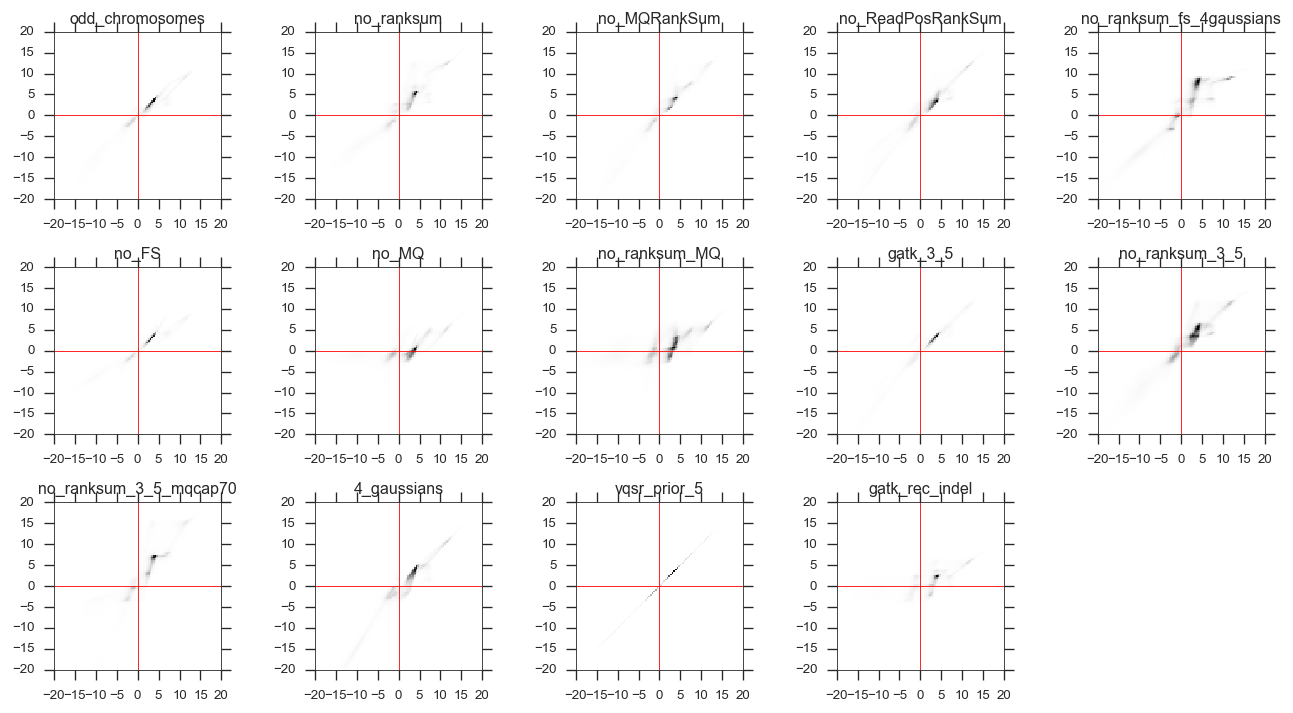

In [46]:
fig_release4_snp=vqsr_plots_all_runs(run_names=['production_build', 'delta'], releases=['release4', 'release4'])
fig_release4_snp.savefig("%s/VQSLOD_release4_vs_delta4_SNP.pdf" % plot_dir)

loading data odd_chromosomes
loading data no_ranksum
loading data no_MQRankSum
loading data no_ReadPosRankSum
loading data no_ranksum_fs_4gaussians
loading data no_FS
loading data no_MQ
loading data no_ranksum_MQ
loading data gatk_3_5
loading data no_ranksum_3_5
loading data no_ranksum_3_5_mqcap70
loading data 4_gaussians
loading data vqsr_prior_5
loading data gatk_rec_indel
creating plot odd_chromosomes
creating plot no_ranksum
creating plot no_MQRankSum
creating plot no_ReadPosRankSum
creating plot no_ranksum_fs_4gaussians
creating plot no_FS
creating plot no_MQ
creating plot no_ranksum_MQ
creating plot gatk_3_5
creating plot no_ranksum_3_5
creating plot no_ranksum_3_5_mqcap70
creating plot 4_gaussians
creating plot vqsr_prior_5
creating plot gatk_rec_indel


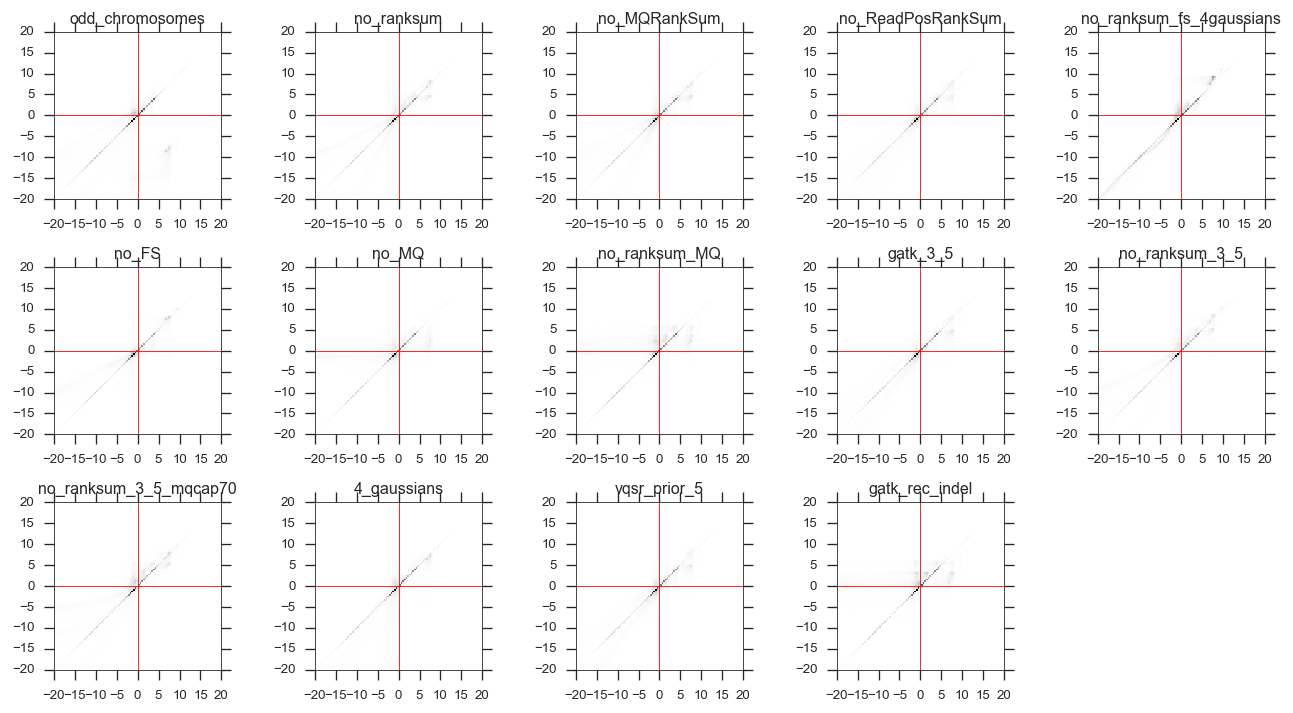

In [47]:
fig_release4_indel=vqsr_plots_all_runs(run_names=['production_build', 'delta'], releases=['release4', 'release4'], mode='INDEL')
fig_release4_indel.savefig("%s/VQSLOD_release4_vs_delta4_INDEL.pdf" % plot_dir)

loading data odd_chromosomes
loading data no_ranksum
loading data no_MQRankSum
loading data no_ReadPosRankSum
loading data no_ranksum_fs_4gaussians
loading data no_FS
loading data no_MQ
loading data no_ranksum_MQ
loading data gatk_3_5
loading data no_ranksum_3_5
loading data no_ranksum_3_5_mqcap70
loading data 4_gaussians
loading data vqsr_prior_5
loading data gatk_rec_indel
creating plot odd_chromosomes
creating plot no_ranksum
creating plot no_MQRankSum
creating plot no_ReadPosRankSum
creating plot no_ranksum_fs_4gaussians
creating plot no_FS
creating plot no_MQ
creating plot no_ranksum_MQ
creating plot gatk_3_5
creating plot no_ranksum_3_5
creating plot no_ranksum_3_5_mqcap70
creating plot 4_gaussians
creating plot vqsr_prior_5
creating plot gatk_rec_indel


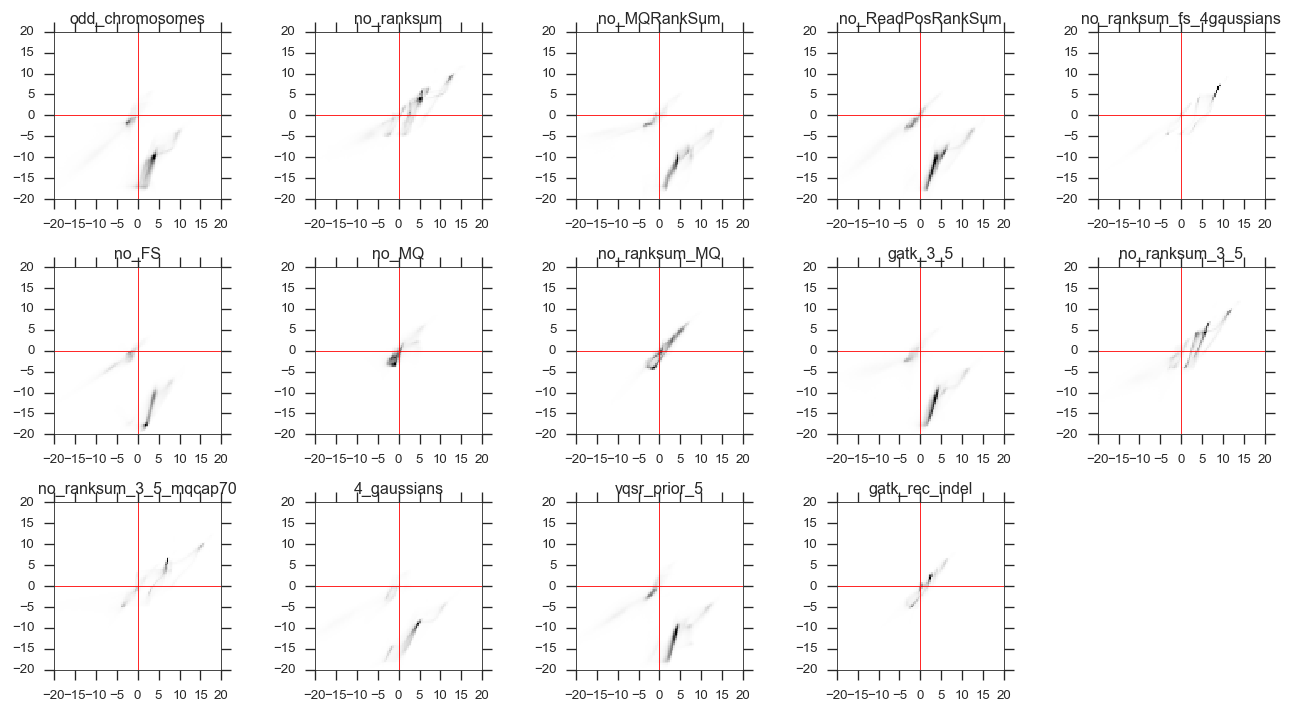

In [48]:
fig_4_vs_5_snp=vqsr_plots_all_runs(run_names=['delta', 'delta'], releases=['release4', 'interim5'])
fig_4_vs_5_snp.savefig("%s/VQSLOD_delta4_vs_delta5_SNP.pdf" % plot_dir)

loading data odd_chromosomes
loading data no_ranksum
loading data no_MQRankSum
loading data no_ReadPosRankSum
loading data no_ranksum_fs_4gaussians
loading data no_FS
loading data no_MQ
loading data no_ranksum_MQ
loading data gatk_3_5
loading data no_ranksum_3_5
loading data no_ranksum_3_5_mqcap70
loading data 4_gaussians
loading data vqsr_prior_5
loading data gatk_rec_indel
creating plot odd_chromosomes
creating plot no_ranksum
creating plot no_MQRankSum
creating plot no_ReadPosRankSum
creating plot no_ranksum_fs_4gaussians
creating plot no_FS
creating plot no_MQ
creating plot no_ranksum_MQ
creating plot gatk_3_5
creating plot no_ranksum_3_5
creating plot no_ranksum_3_5_mqcap70
creating plot 4_gaussians
creating plot vqsr_prior_5
creating plot gatk_rec_indel


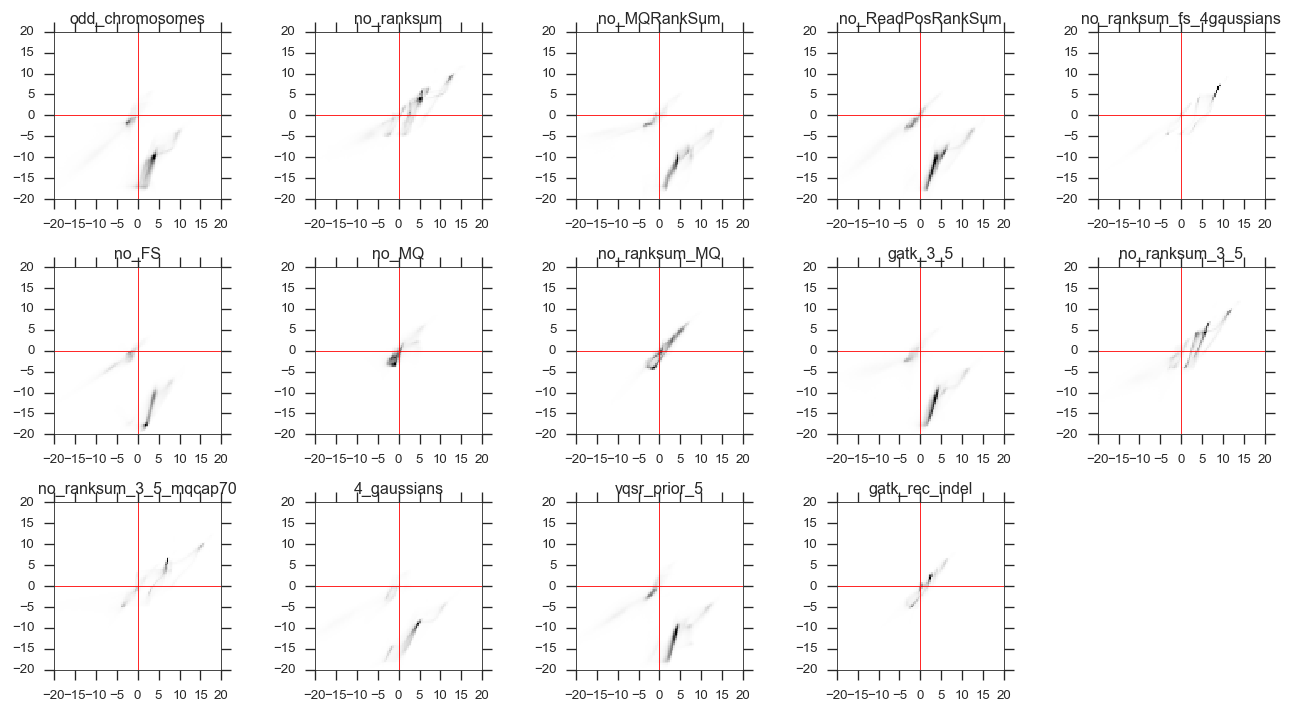

In [49]:
fig_4_vs_5_indel=vqsr_plots_all_runs(run_names=['delta', 'delta'], releases=['release4', 'interim5'])
fig_4_vs_5_indel.savefig("%s/VQSLOD_delta4_vs_delta5_INDEL.pdf" % plot_dir)

In [19]:
temp = np.load('/nfs/team112_internal/rp7/data/pf3k/release4/vqsr/production_build/release4_WG_sites.filtered.vcf.gz.vcfnp_cache/variants.npy'
              )[['CHROM', 'POS', 'is_snp', 'RegionType', 'VQSLOD']]

FileNotFoundError: [Errno 2] No such file or directory: '/nfs/team112_internal/rp7/data/pf3k/release4/vqsr/production_build/release4_WG_sites.filtered.vcf.gz.vcfnp_cache/variants.npy'

In [81]:
np.unique(temp['VQSLOD'] > 0.0, return_counts=True)

(array([False,  True], dtype=bool), array([2185983, 2014893]))

In [82]:
num_pass_snps = np.sum(
                (temp['is_snp']) &
#                 (vqslod[run_name][release]['RegionType'] == 'Core') &
                (temp['VQSLOD'] > 0.0)
            )

In [83]:
num_pass_snps

1329272

In [87]:
np.unique(temp['RegionType'], return_counts=True)

(array([b'', b'Centromere', b'Core', b'InternalHypervariable',
        b'SubtelomericHypervariable', b'SubtelomericRepeat'], 
       dtype='|S25'),
 array([   4983,    4617, 2882037,  182699,  715407,  411133]))